In [1]:
import sys
# Hay que ejecutar esta línea antes de importar el módulo.
#sys.path.append("C:/Users/Vicen/PycharmProjects/tgpy")
# Ahora se puede importar el módulo.
%reload_ext tgpy
import tgpy as tg
import matplotlib.pyplot as plt
import mpl_scatter_density
import utm
import pydeck as pdk
import pandas as pd
import numpy as np
import seaborn as sb
import random
from scipy import signal
from sklearn.metrics import mean_absolute_error

In [2]:
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)



# Funcion de extrarccion de parametros:

In [3]:
def get_priors_dt(self, npriors: int):
    """
    Save the value of sample in a dict

    :param npriors: an int, the number of groups
    :return: a dict, value of sample for each prior and group
    """
    prior_dict = {}
    for i in range(npriors):
            prior_dict[('prior{}'.format(i), 'Year')] = self._priors_dict['prior{}'.format(i)].p[
                'Year'].data.clone().detach().cpu().numpy() # se ha adecuar a los como se guardo el dict de los parametros
    return prior_dict

In [4]:
Sunspots = pd.read_csv('Sunspots.csv')
Sunspots['year'] = pd.DatetimeIndex(Sunspots['Date']).year
Sunspots_train_anual = Sunspots[['year','Monthly Mean Total Sunspot Number']]
Sunspots_train_anual = Sunspots_train_anual.groupby("year", as_index=False).mean()
Sunspots_train_anual = Sunspots_train_anual.iloc[51:272]
(Sunspots_train_anual).reset_index(inplace=True, drop=True)
S_train = Sunspots_train_anual

In [5]:
S_train['year']

0      1800
1      1801
2      1802
3      1803
4      1804
       ... 
216    2016
217    2017
218    2018
219    2019
220    2020
Name: year, Length: 221, dtype: int64

In [7]:


t_anual = S_train["year"]-S_train["year"]
y_anual = S_train["Monthly Mean Total Sunspot Number"]
prop = 0.8
obs = int(prop*len(t_anual))
train_index_anual = list(range(obs))
valid_index_anual = list(range(obs,len(t_anual)))
t_obs_anual = t_anual[train_index_anual]
y_obs_anual = y_anual[train_index_anual]
t_val = t_anual[valid_index_anual]
y_val = y_anual[valid_index_anual]



In [8]:
valid_index_anual


[176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220]

In [9]:
S_train['Monthly Mean Total Sunspot Number'].mean()

79.72021116138765

In [10]:
y_obs_anual

0      24.125000
1      56.650000
2      75.050000
3      71.750000
4      79.108333
         ...    
171    94.425000
172    97.691667
173    54.291667
174    49.150000
175    22.408333
Name: Monthly Mean Total Sunspot Number, Length: 176, dtype: float64

In [11]:
print(len(t_anual),len(t_obs_anual))

221 176


In [12]:
def train(tgp, sample_priors=True, niters=1000):
    if sample_priors:
        tgp.sample_priors()
        tgp.plot_priors(kde=True)
    learning = tg.TgLearning(tgp, lr=0.01, pbatch=0.8) #rand_pert=0.0
    learning.execute_sgd(niters)
    tgp.plot_priors(kde=True)

In [13]:
train_index_anual = sorted(tg.np.random.choice(train_index_anual, 100))

# Modelo Kernel SE

In [14]:
import scipy as sp

In [76]:
def model(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs, device='cuda')
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_se = tg.TgPrior('var', ['Sunspots'], dim=dim, low=0.0, high=4.0, alpha=4, beta=2)
    
    relevance = tg.TgPrior('relevance', ['year'], dim=dim, low=1, high=10, alpha=2, beta=4) #low = 0.0, high = 2
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.0, high=0.1, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    var_sm = tg.TgPrior('var_sm', ['var_sm'], dim=dim, low=0.0, high=4.0, alpha=4, beta=2)
    relevance_sm = tg.TgPrior('relevance_sm', ['relevance_sm'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period = tg.TgPrior('period', ['period'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel_sm = tg.SM(var_sm, relevance_sm, period)
    
    
    kernel = tg.SE(var_se, relevance)
    cov = tg.CovarianceTransport(kernel + kernel_sm, noise=tg.WN(noise))
    fi = tg.MarginalTransport(tg.Fi())
    marginal = tg.MarginalTransport(tg.Distribution(sp.stats.beta(a=2,b=5, loc=0, scale=2)))

    tgp = tg.TGP([cov,fi, marginal], dt=dt)
    tgp.obs(index_obs)
    return tgp

tgp = model(S_train, train_index_anual)

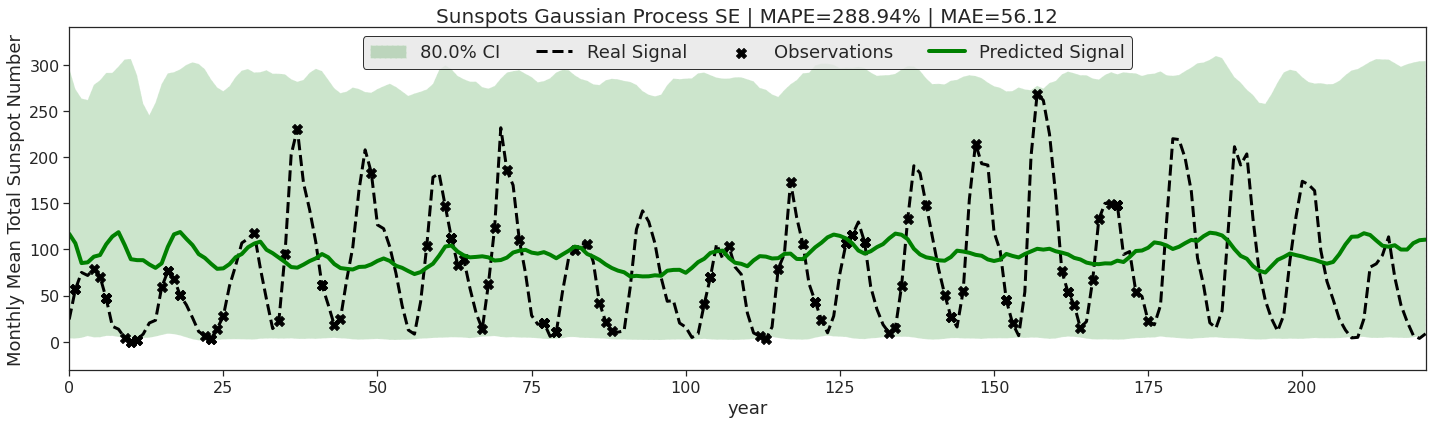

In [77]:
tgp.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median", prior=True)

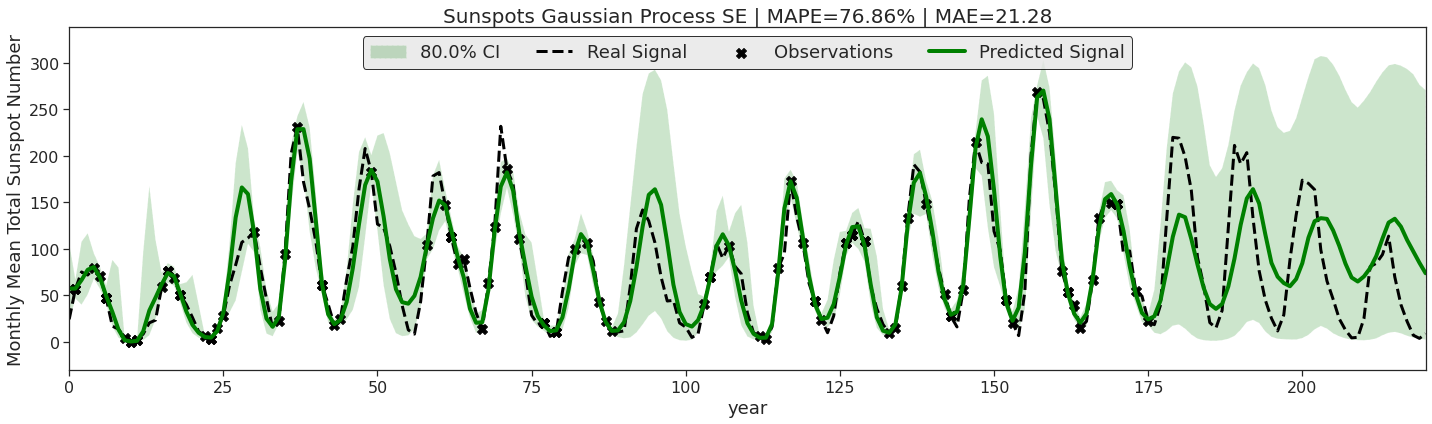

In [78]:
tgp.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

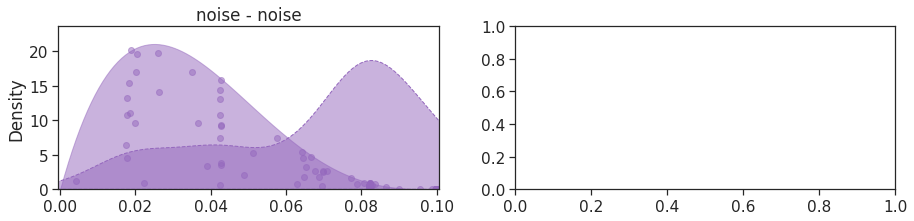

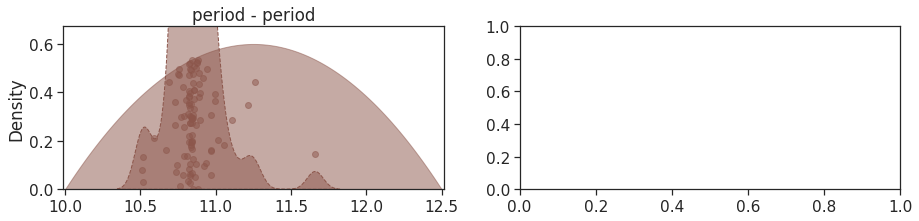

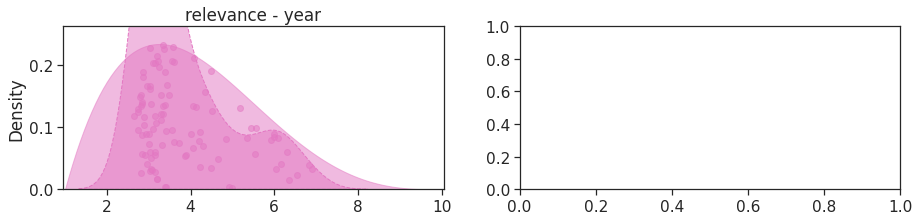

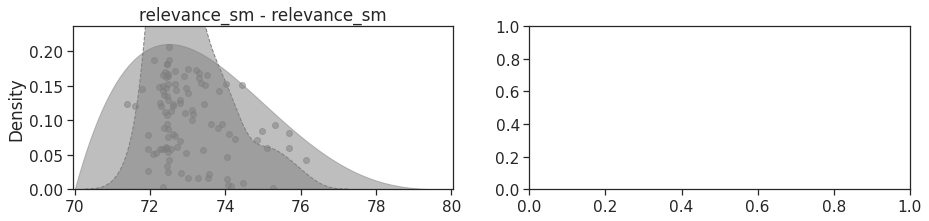

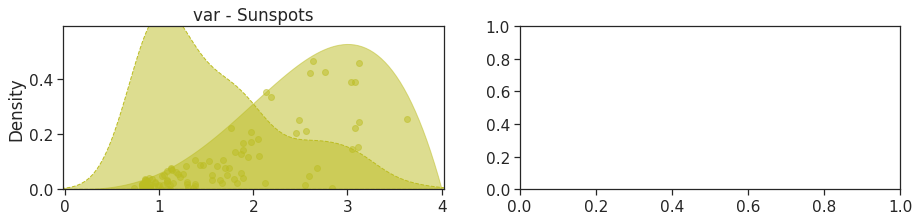

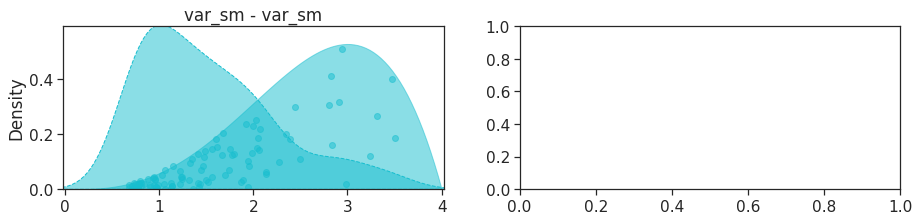

In [79]:
niters = 1000

learning = tg.TgLearning(tgp, lr=0.01, pbatch=0.8) #rand_pert=0.0
learning.execute_sgd(niters)
tgp.plot_priors(kde=True)

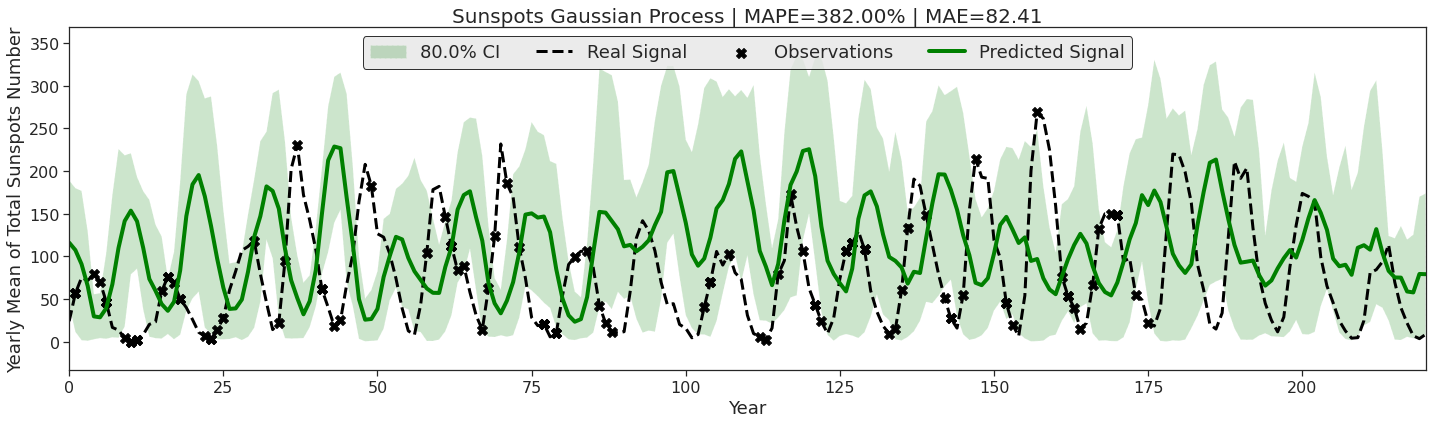

In [80]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number',
                  nsamples = 5, noise=True, plot_samples=False, prior=True,
                  ylim_by_CI=True)

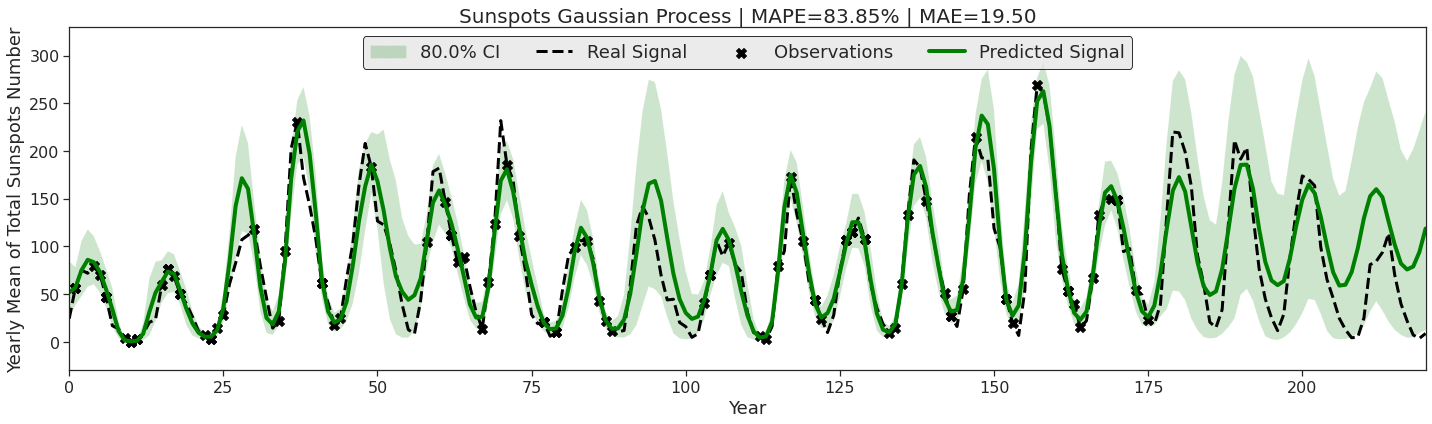

In [81]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number',
                  nsamples = 100, noise=True, plot_samples=False, ylim_by_CI=True)

# Modelo Kernel SM

<AxesSubplot: >

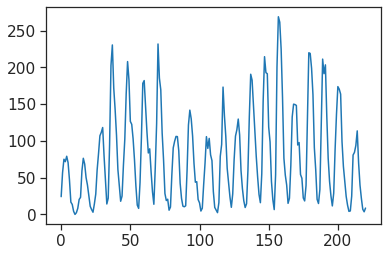

In [21]:
y_anual.plot()

In [22]:
from scipy.signal import periodogram

<ipython-input-23-f606f9c401e2>:2: RuntimeWarning: divide by zero encountered in divide
  tg.plt.plot(1/px, py)


(0.0, 15.0)

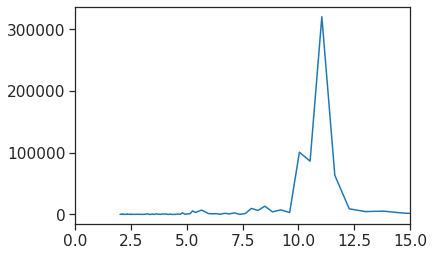

In [23]:
px, py = periodogram(y_anual.values)
tg.plt.plot(1/px, py)
tg.plt.xlim([0,15])

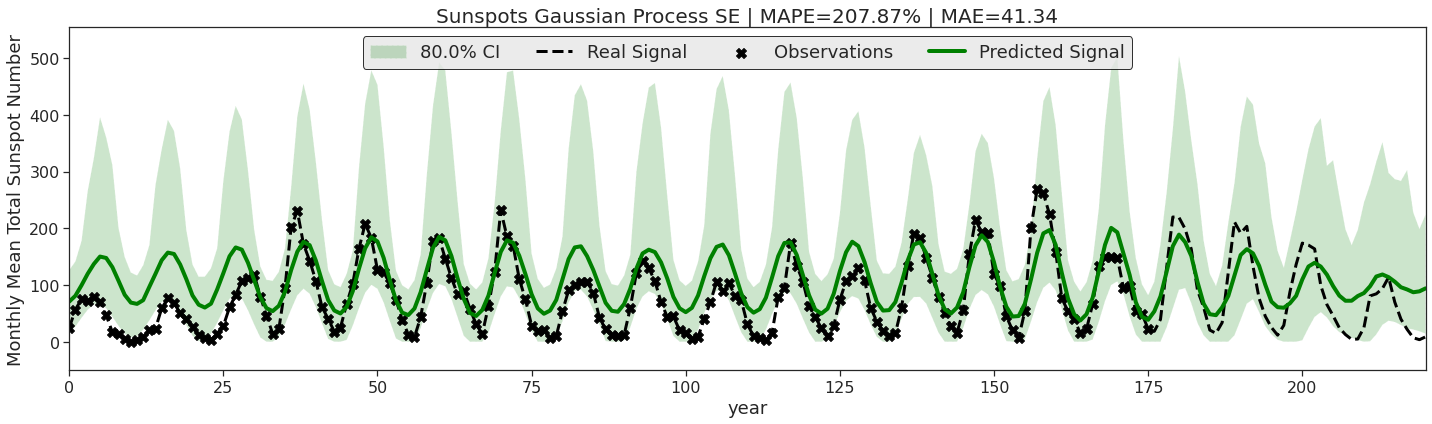

In [24]:
def model_sm(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_sm = tg.TgPrior('var', ['var'], dim=dim, low=0.0, high=0.05, alpha=4, beta=2)
    relevance = tg.TgPrior('relevance', ['relevance'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period = tg.TgPrior('period', ['period'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel = tg.SM(var_sm, relevance, period)
    
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    cov = tg.CovarianceTransport(kernel, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

tgp_sm = model_sm(S_train, train_index_anual)

tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

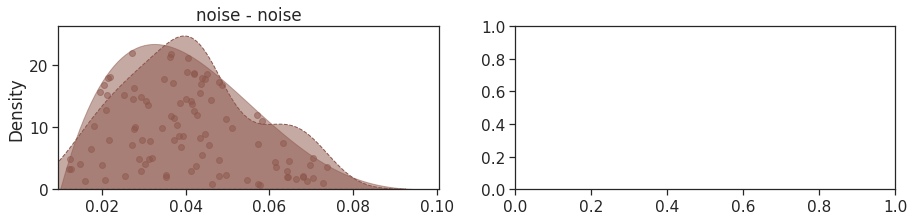

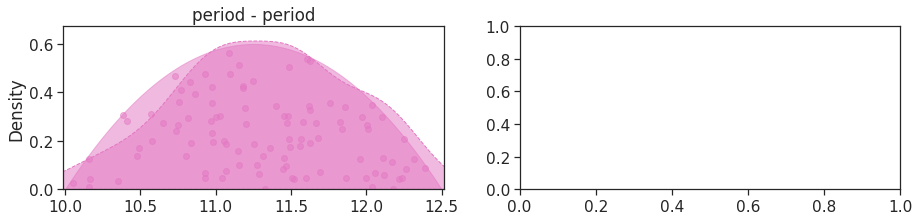

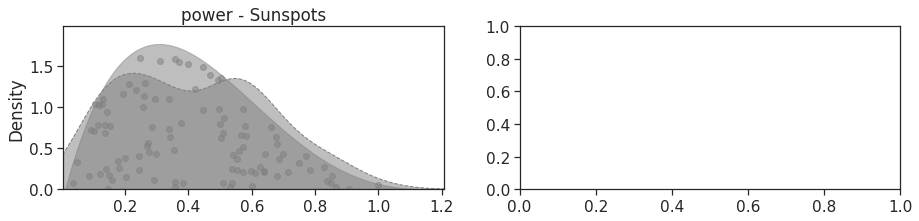

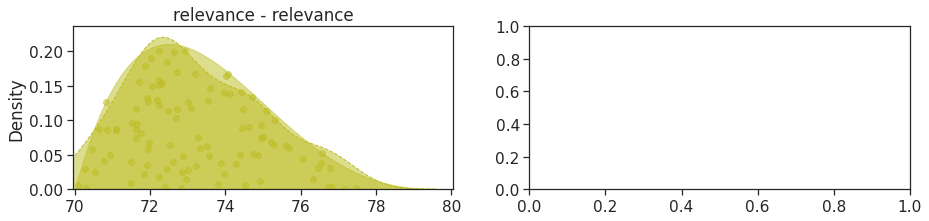

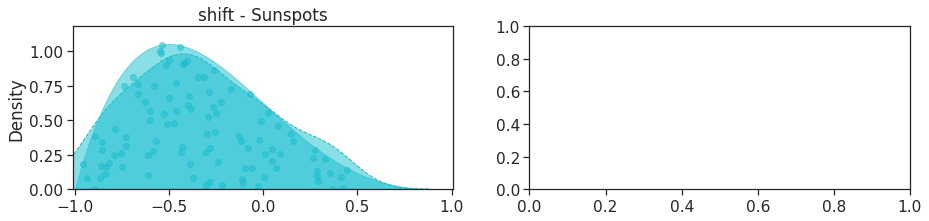

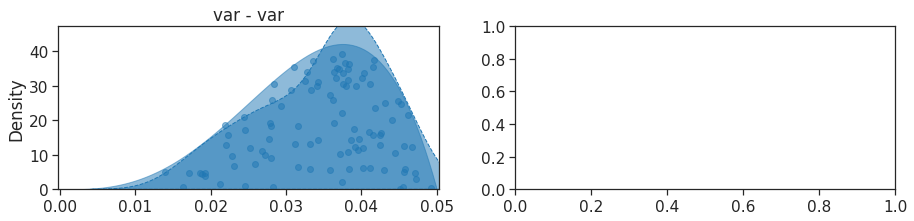

  0%|                                                                                                         …

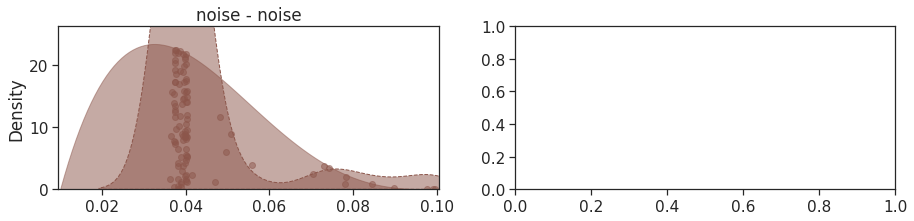

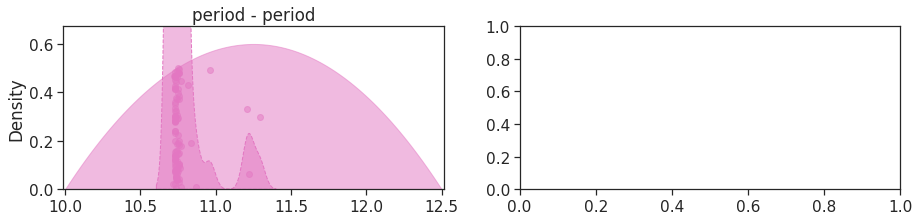

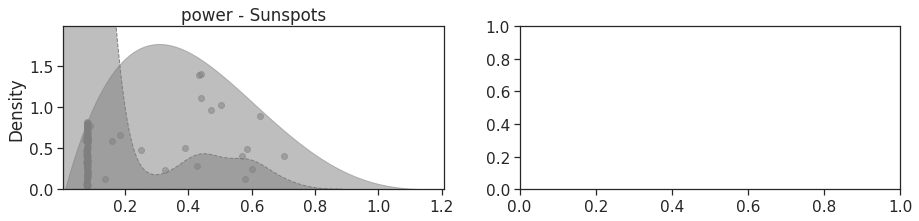

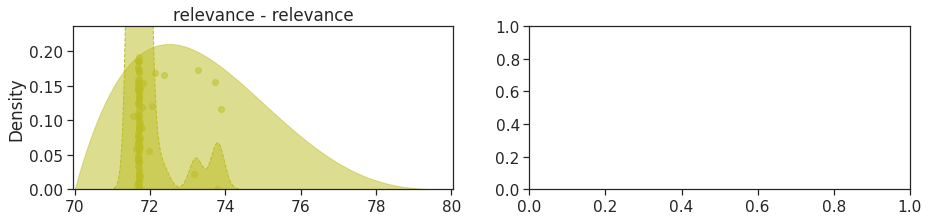

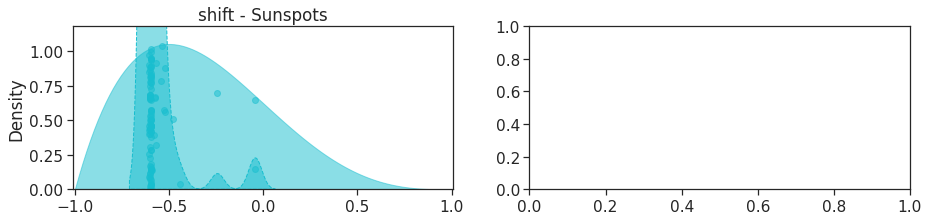

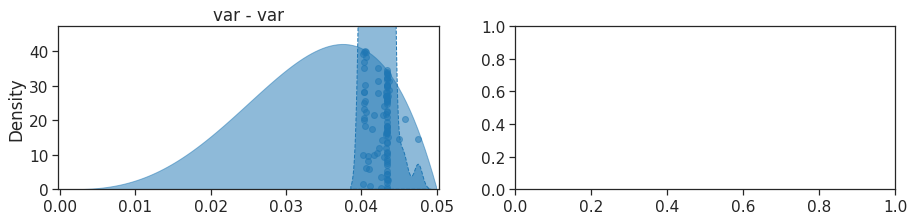

In [25]:
train(tgp_sm)

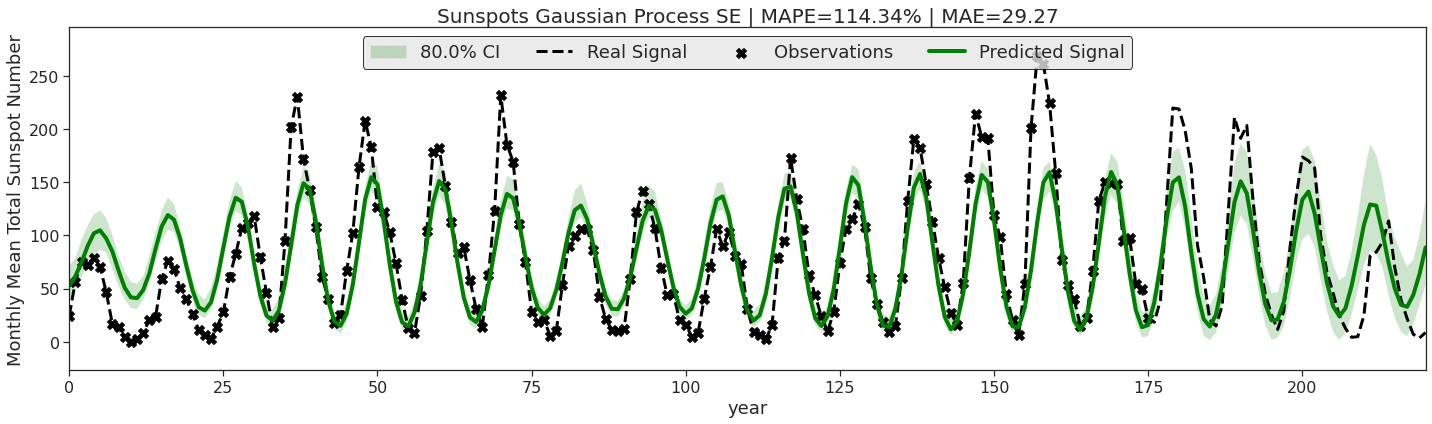

In [26]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

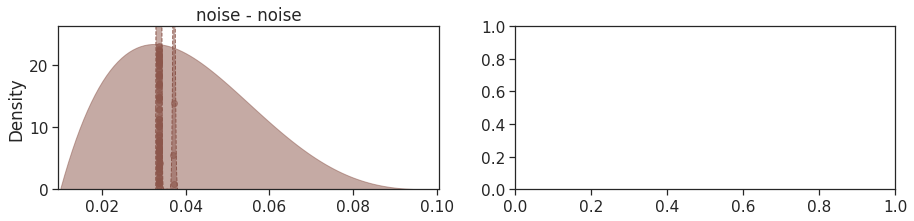

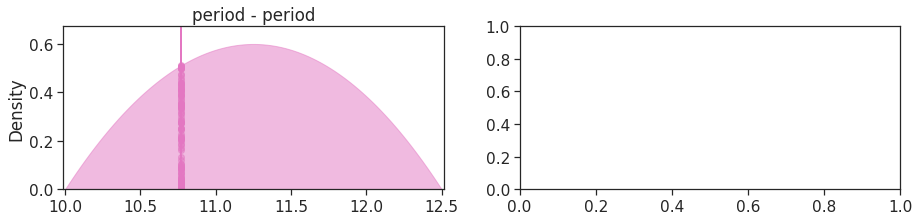

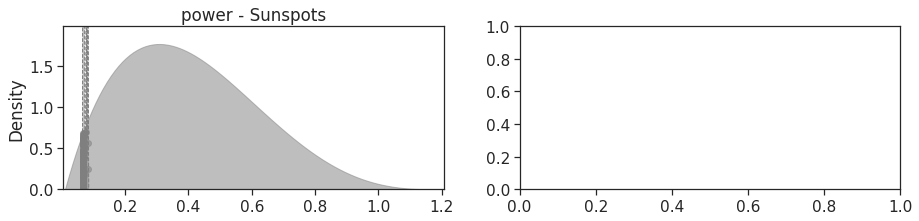

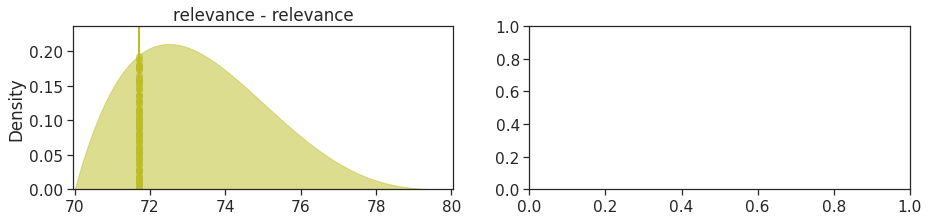

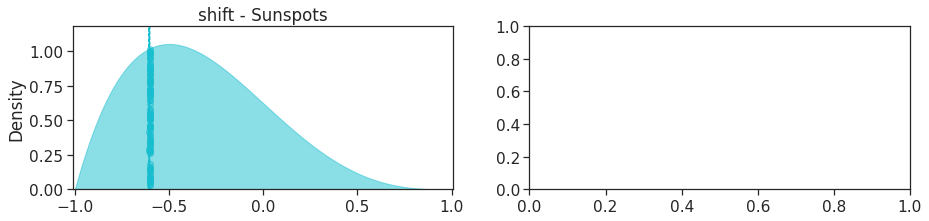

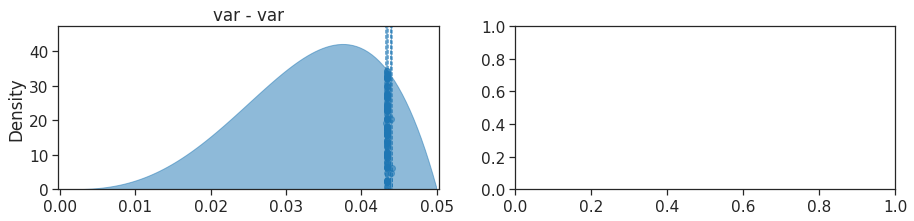

In [27]:
train(tgp_sm, sample_priors=False)

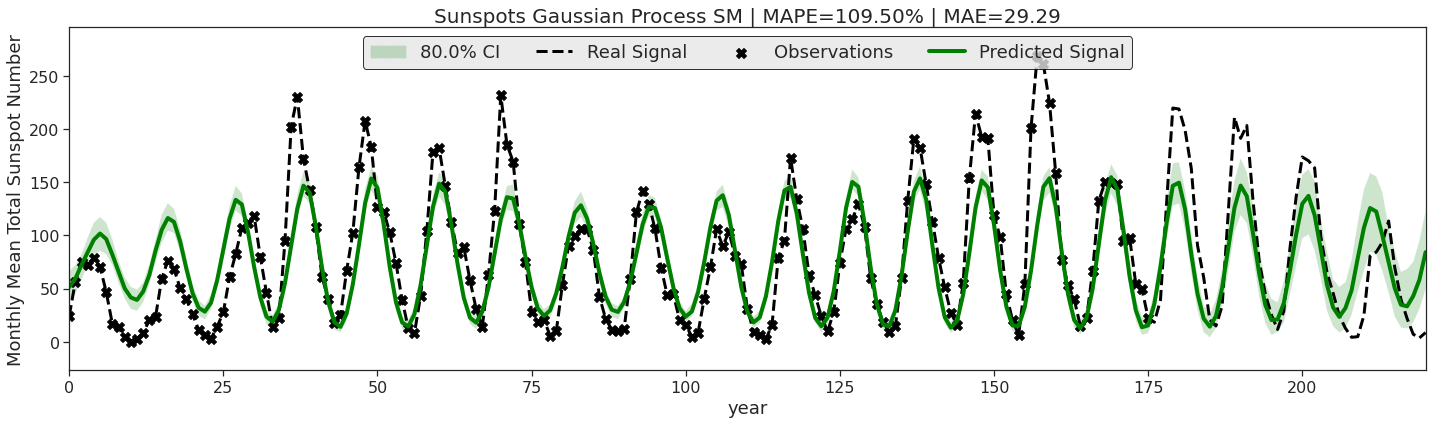

In [28]:
tgp_sm.plot_predict('Sunspots Gaussian Process SM', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

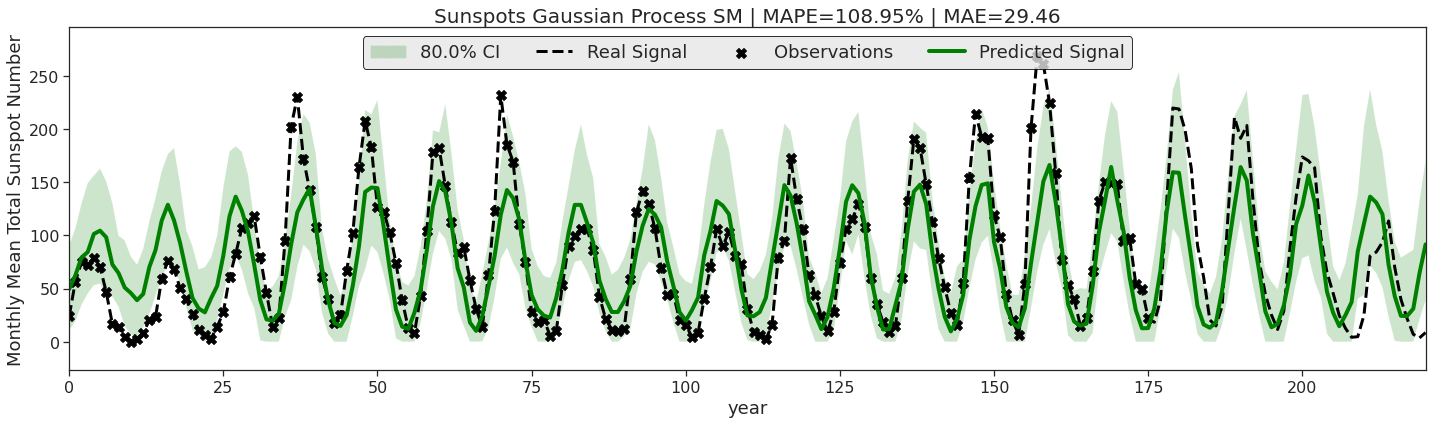

In [29]:
tgp_sm.plot_predict('Sunspots Gaussian Process SM', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=True, plot_samples=False, statistic="Median")

# Modelo Kernel SM + SM

<AxesSubplot: >

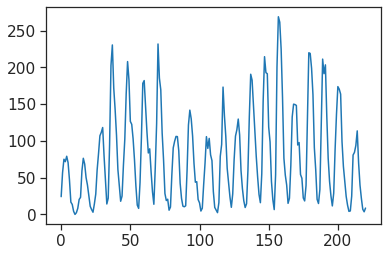

In [30]:
y_anual.plot()

In [31]:
from scipy.signal import periodogram

<ipython-input-32-397a1ae4f2d2>:3: RuntimeWarning: divide by zero encountered in divide
  tg.plt.plot(1/px, py)


(0.0, 150.0)

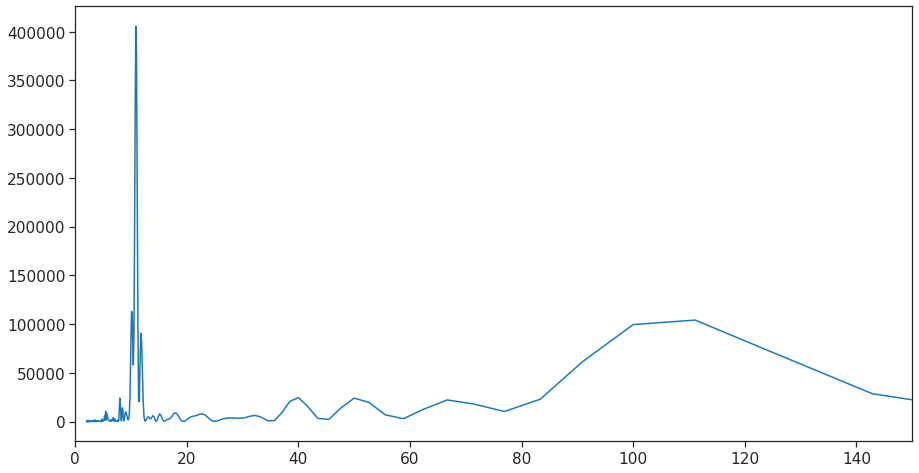

In [32]:
px, py = periodogram(y_anual.values, nfft=1000)
tg.plt.figure(1, figsize=(15,8))
tg.plt.plot(1/px, py)
tg.plt.xlim([0,150])

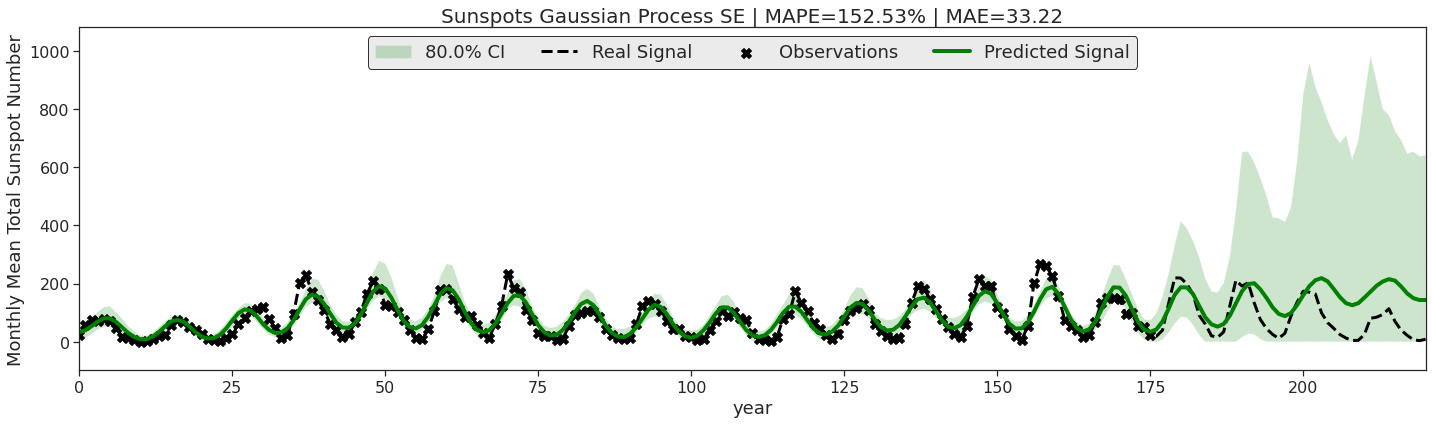

In [33]:
def model_sm(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_sm1 = tg.TgPrior('var1', ['var1'], dim=dim, low=0.0, high=0.05, alpha=4, beta=2)
    relevance1 = tg.TgPrior('relevance1', ['relevance1'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period1 = tg.TgPrior('period1', ['period1'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel1 = tg.SM(var_sm1, relevance1, period1)
    
    var_sm2 = tg.TgPrior('var2', ['var2'], dim=dim, low=0.0, high=0.05, alpha=4, beta=2)
    relevance2 = tg.TgPrior('relevance2', ['relevance2'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period2 = tg.TgPrior('period2', ['period2'], dim=dim, low=90, high=120, alpha=2, beta=2)
    kernel2 = tg.SM(var_sm2, relevance2, period2)
    
    
    
    
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    cov = tg.CovarianceTransport(kernel1 + kernel2, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

tgp_sm = model_sm(S_train, train_index_anual)

tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

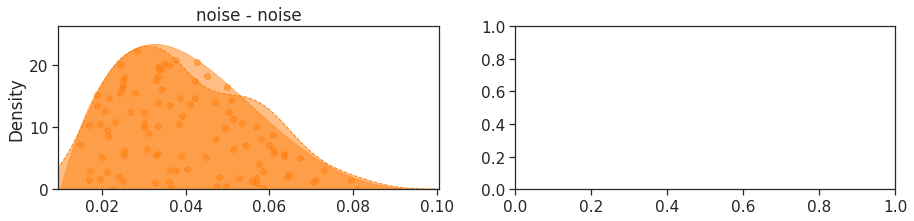

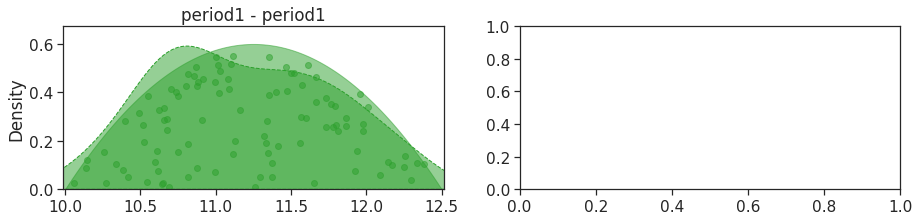

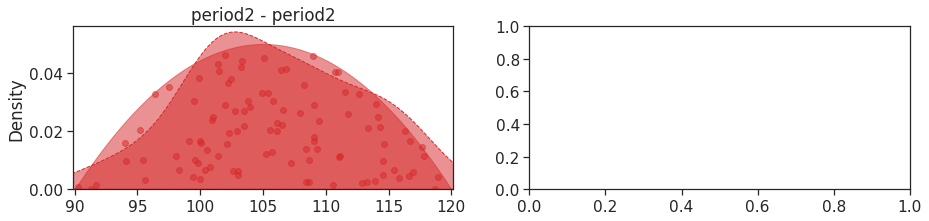

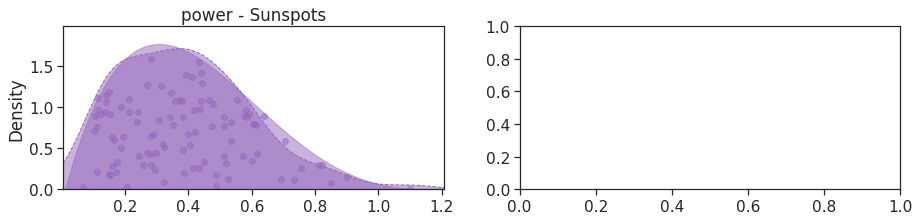

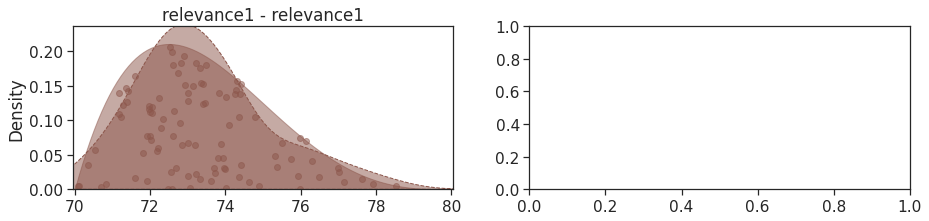

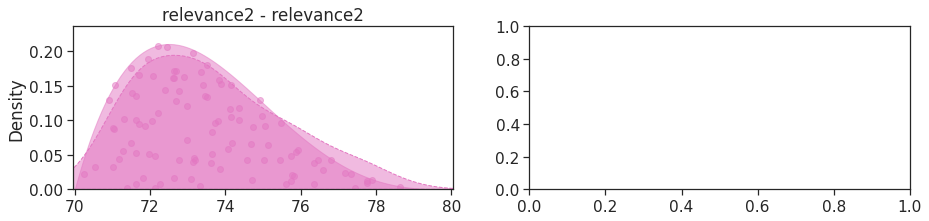

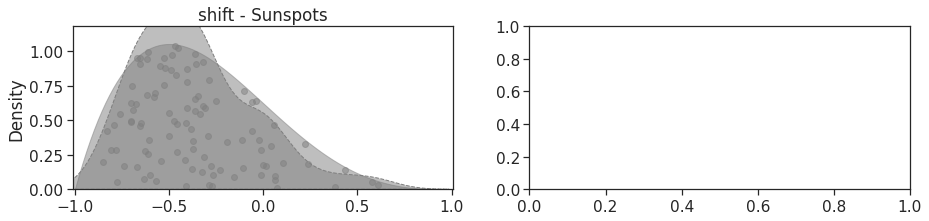

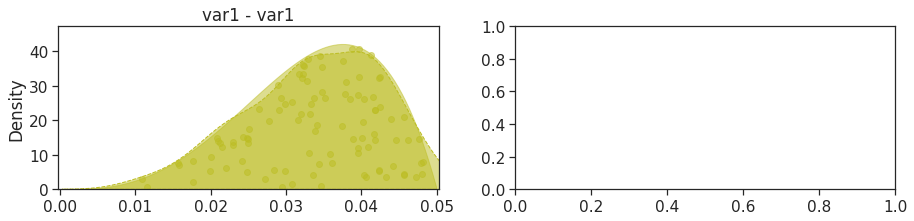

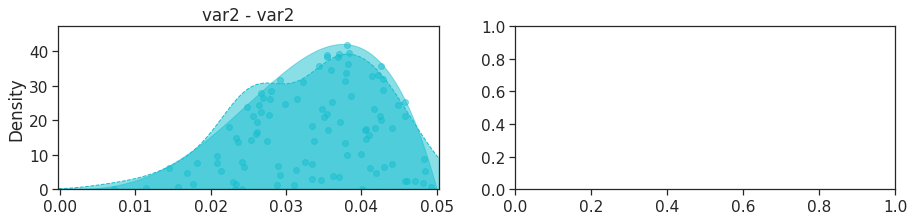

  0%|                                                                                                         …

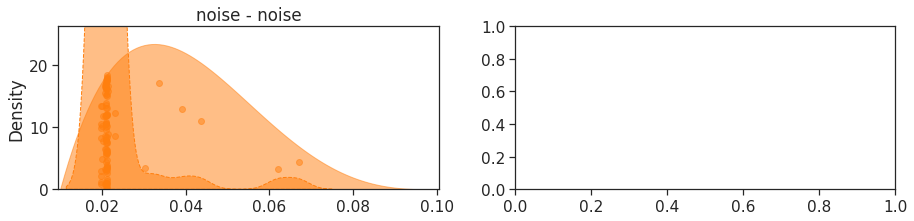

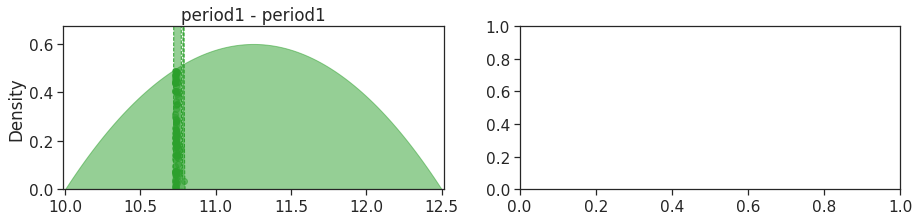

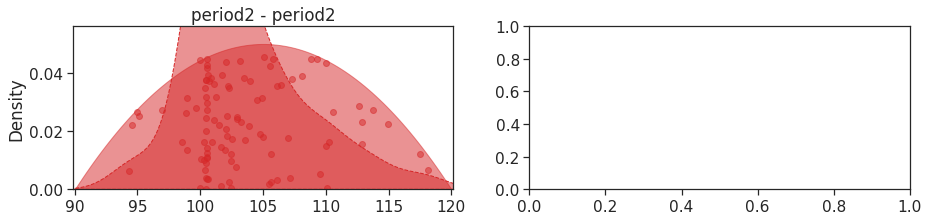

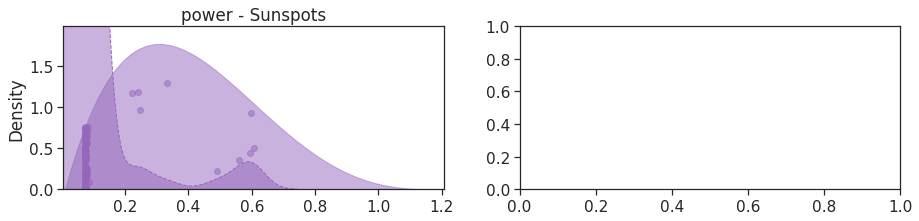

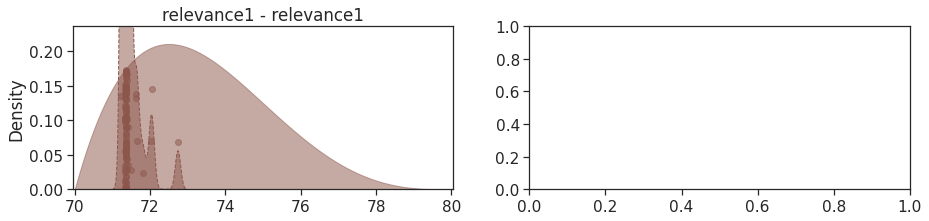

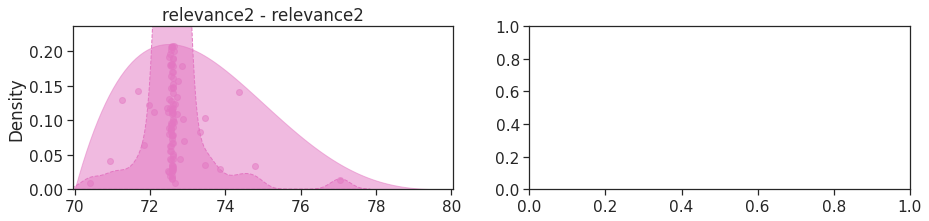

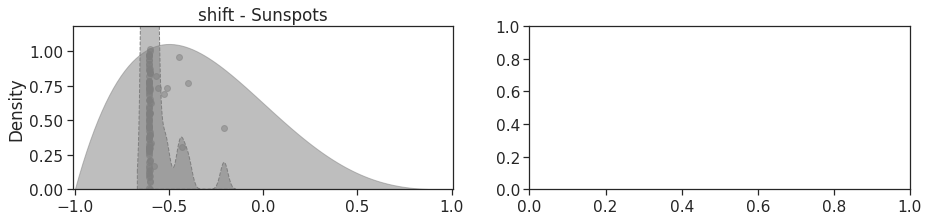

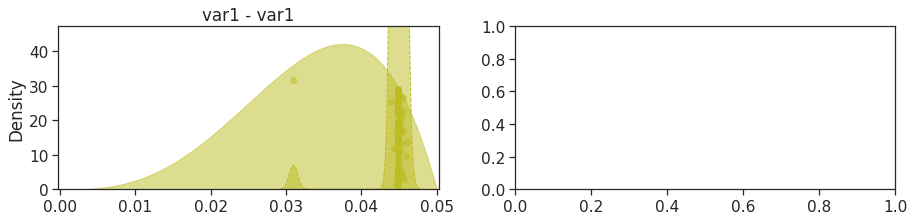

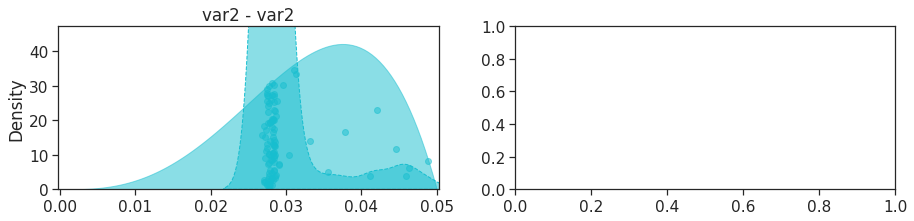

In [34]:
train(tgp_sm)

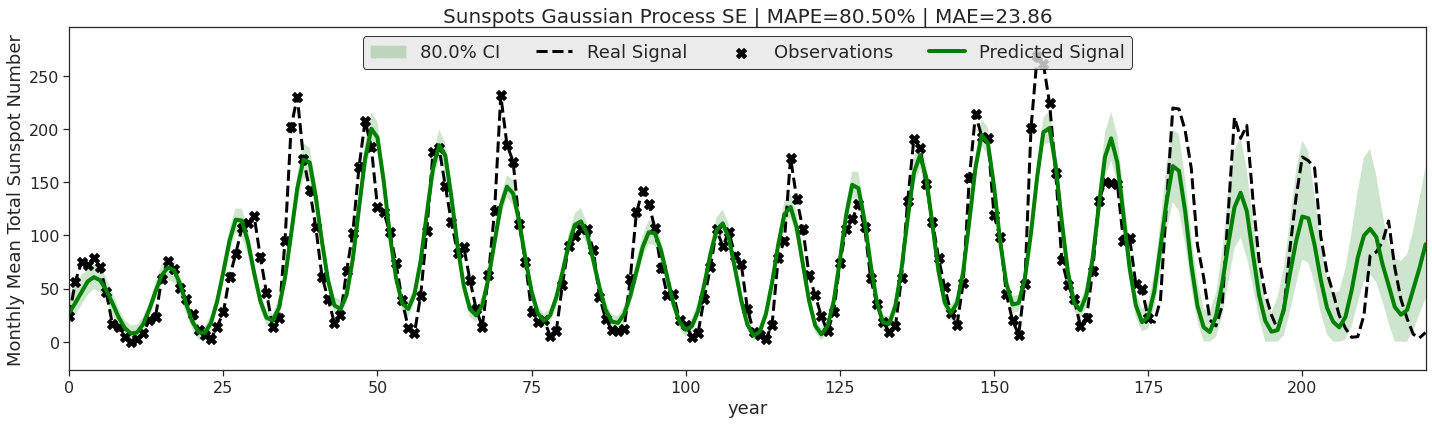

In [35]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

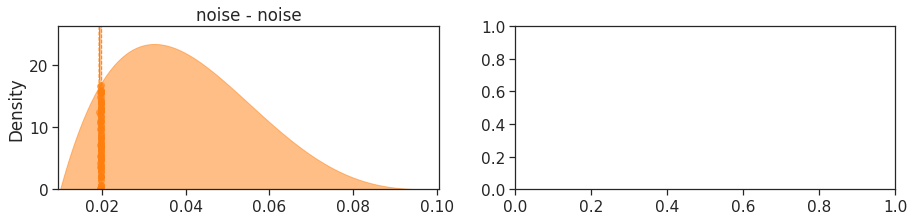

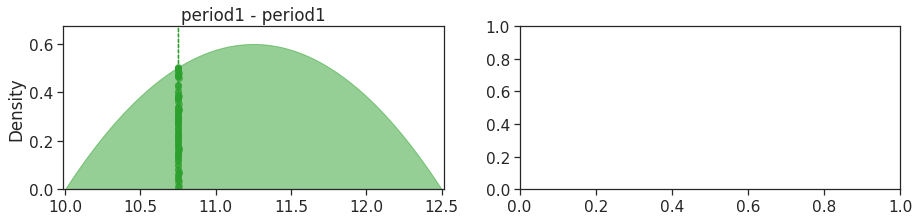

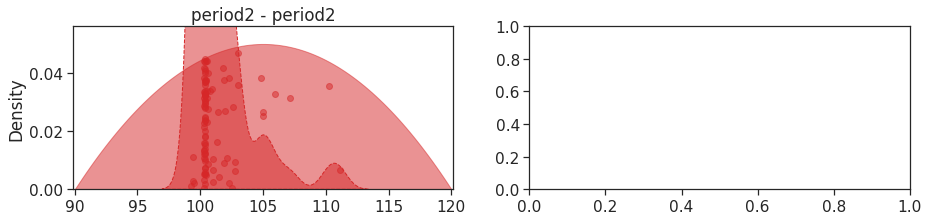

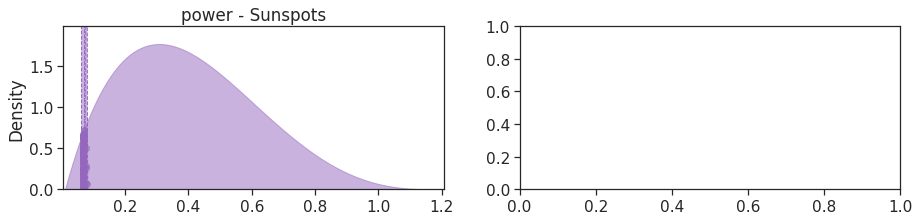

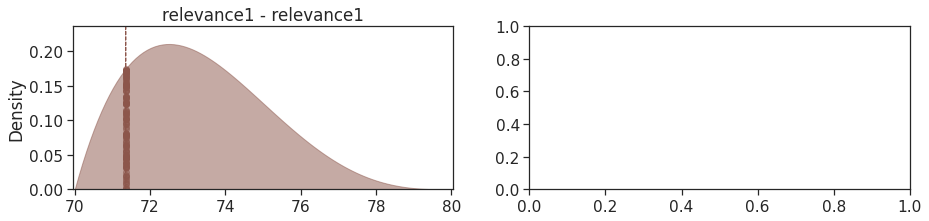

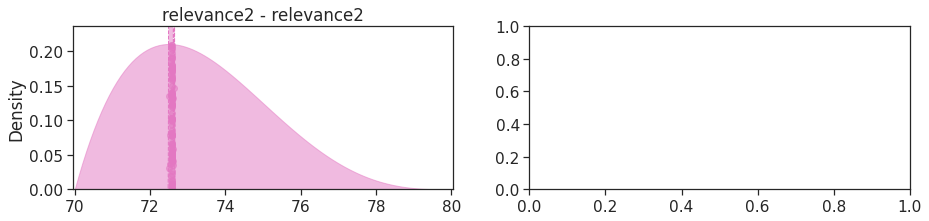

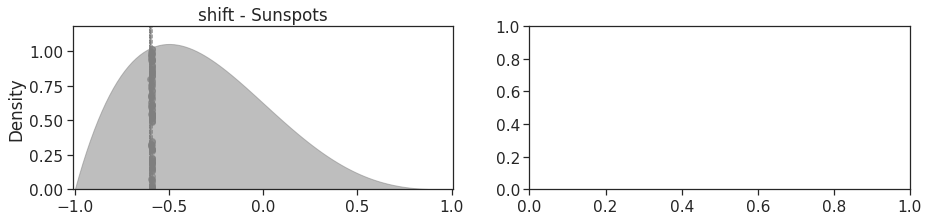

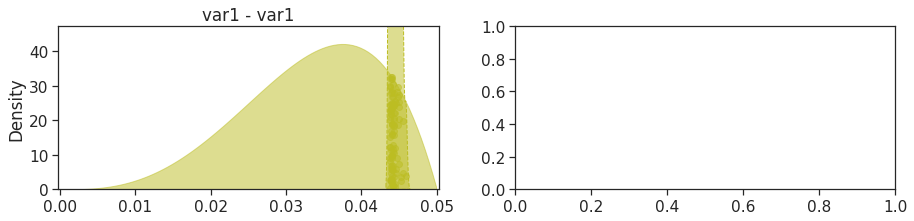

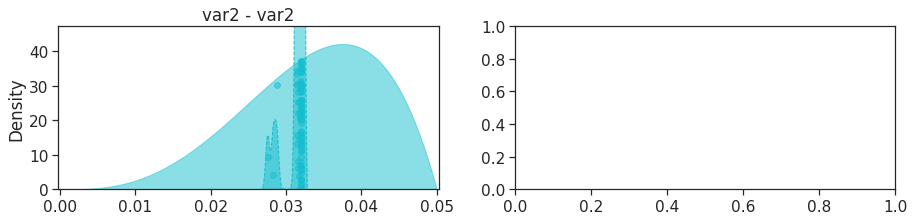

In [36]:
train(tgp_sm, sample_priors=False)

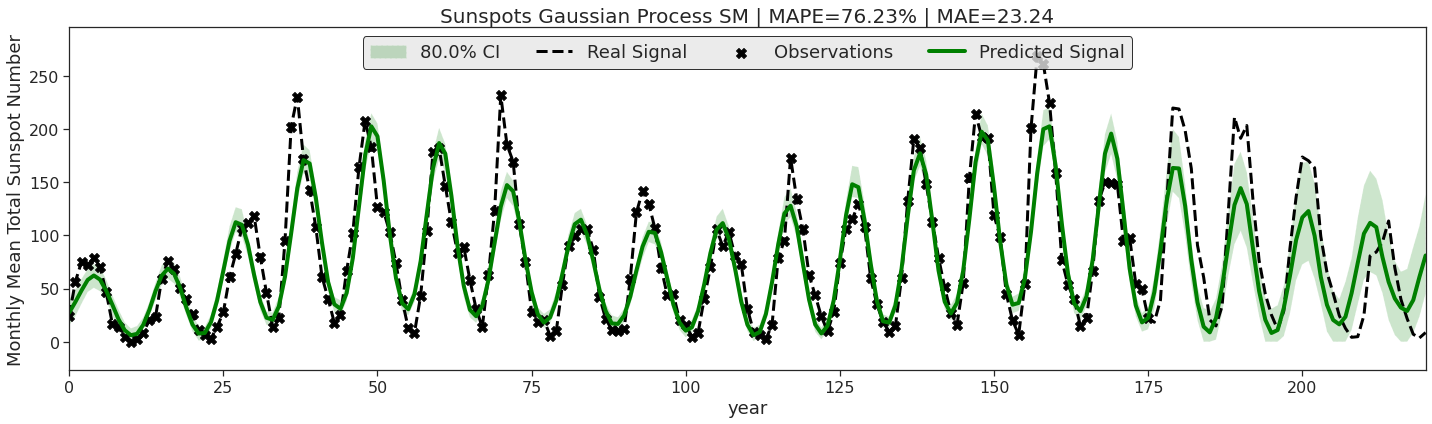

In [37]:
tgp_sm.plot_predict('Sunspots Gaussian Process SM', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

# Modelo Kernel SM + SM + SE

<AxesSubplot: >

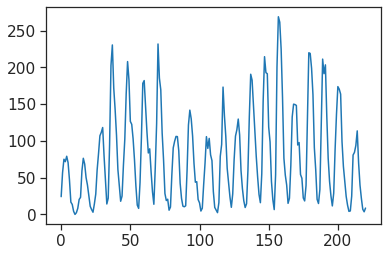

In [38]:
y_anual.plot()

In [39]:
from scipy.signal import periodogram

<ipython-input-40-397a1ae4f2d2>:3: RuntimeWarning: divide by zero encountered in divide
  tg.plt.plot(1/px, py)


(0.0, 150.0)

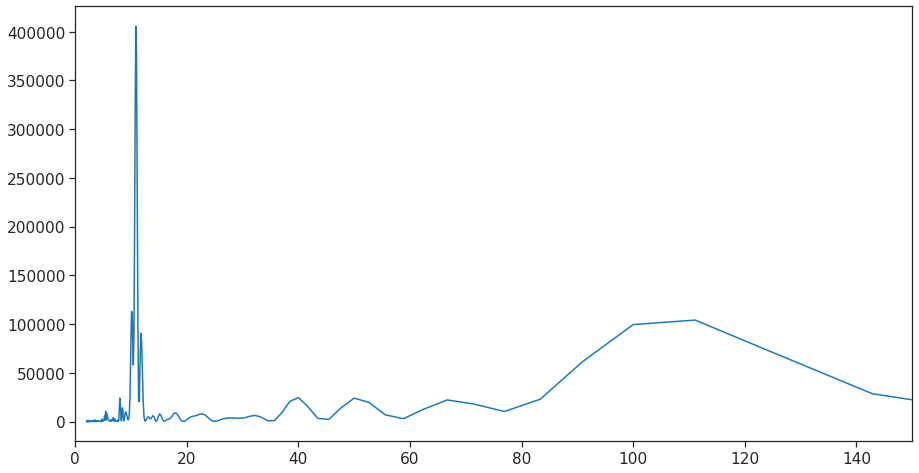

In [40]:
px, py = periodogram(y_anual.values, nfft=1000)
tg.plt.figure(1, figsize=(15,8))
tg.plt.plot(1/px, py)
tg.plt.xlim([0,150])

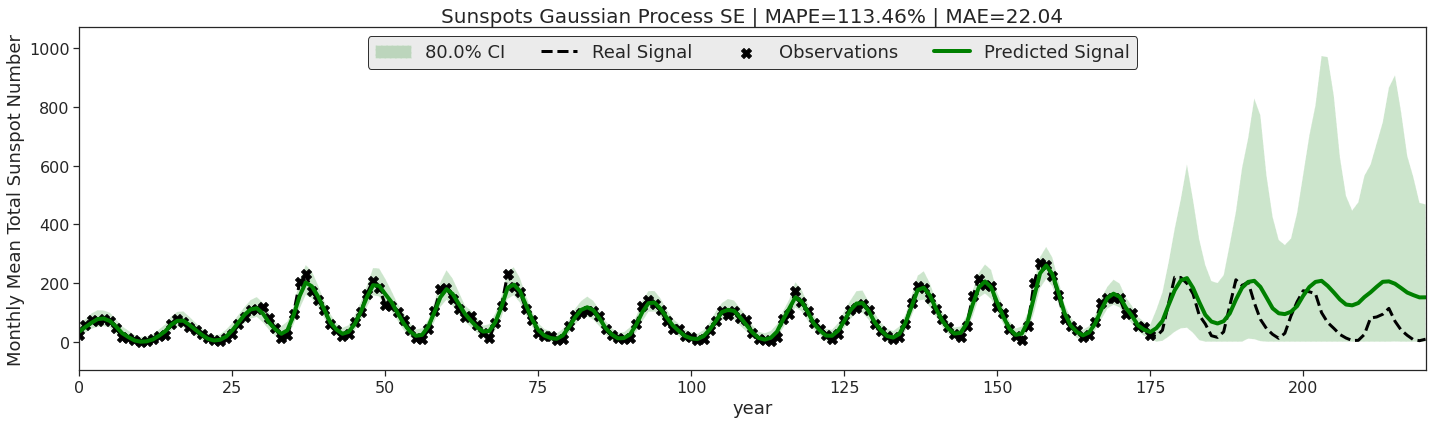

In [41]:
def model_sm(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_sm1 = tg.TgPrior('var1', ['var1'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance1 = tg.TgPrior('relevance1', ['relevance1'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period1 = tg.TgPrior('period1', ['period1'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel1 = tg.SM(var_sm1, relevance1, period1)
    
    var_sm2 = tg.TgPrior('var2', ['var2'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance2 = tg.TgPrior('relevance2', ['relevance2'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period2 = tg.TgPrior('period2', ['period2'], dim=dim, low=90, high=120, alpha=2, beta=2)
    kernel2 = tg.SM(var_sm2, relevance2, period2)
    
    var_se = tg.TgPrior('var3', ['var3'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance3 = tg.TgPrior('relevance3', ['relevance3'], dim=dim, low=0, high=10, alpha=2, beta=4) 
    kernel3 = tg.SE(var_se, relevance3)   
    
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    cov = tg.CovarianceTransport(kernel1 + kernel2 + kernel3, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

tgp_sm = model_sm(S_train, train_index_anual)

tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

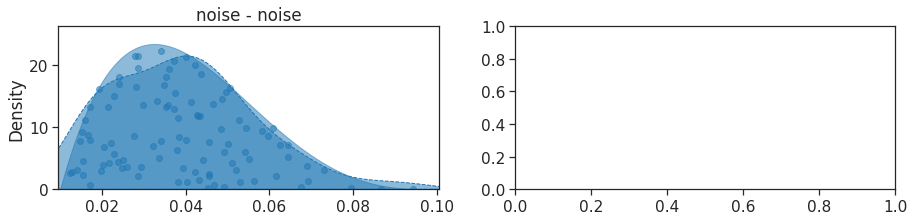

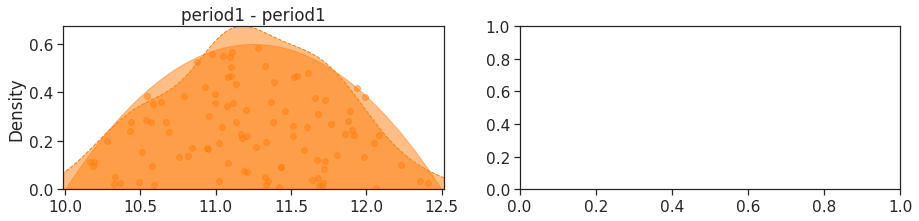

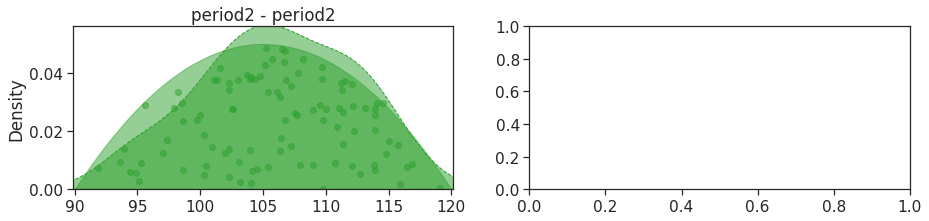

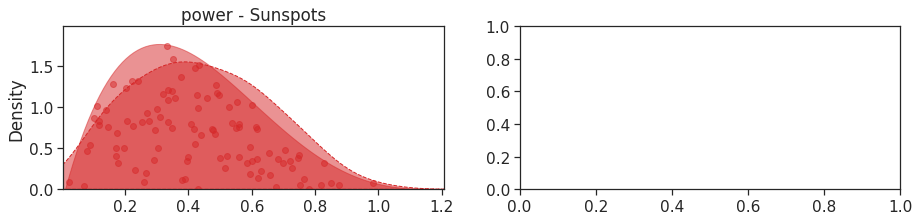

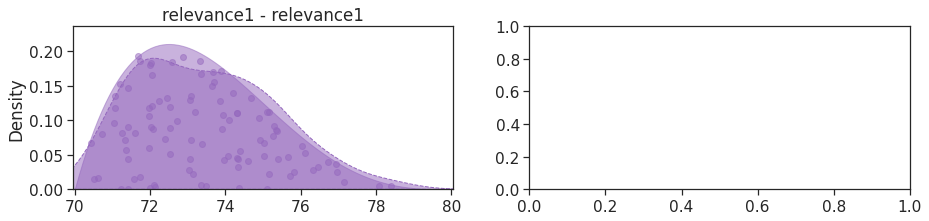

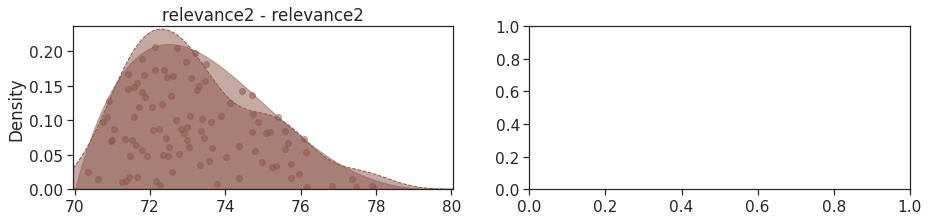

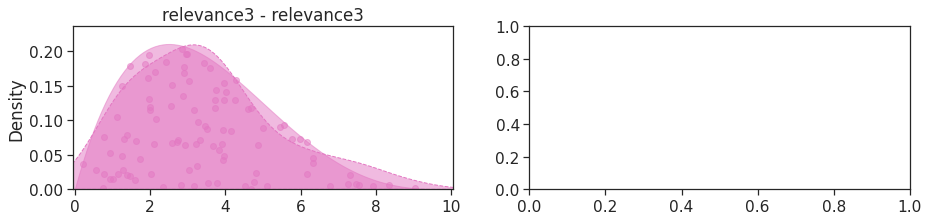

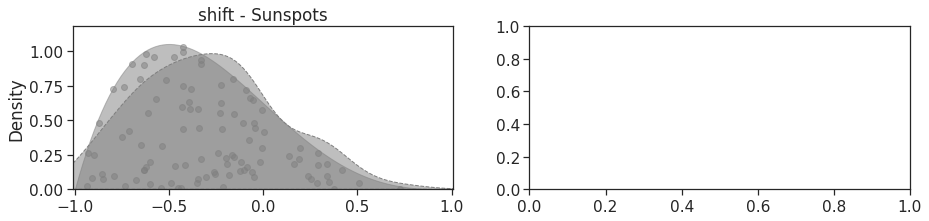

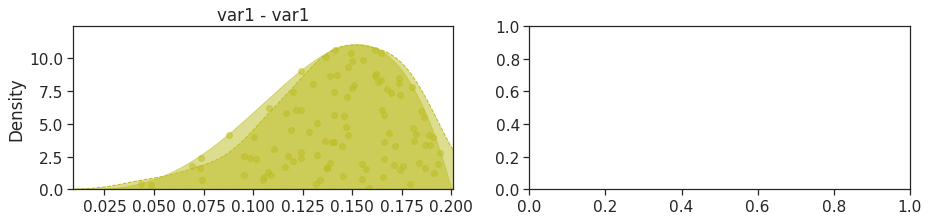

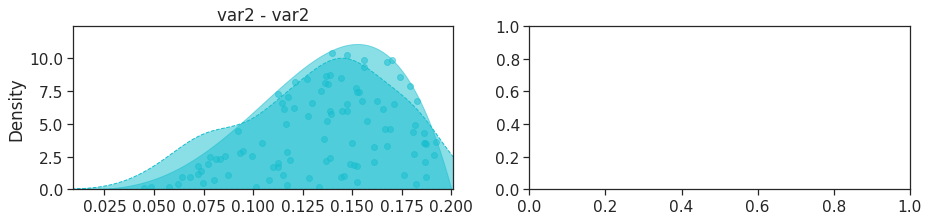

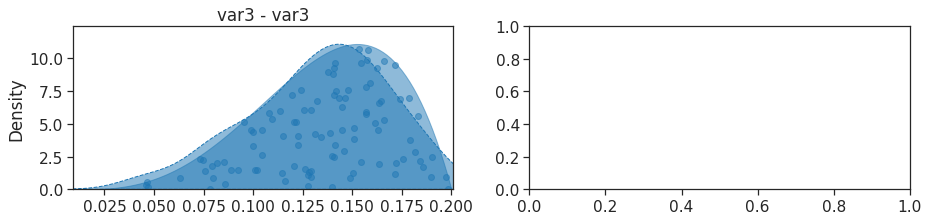

  0%|                                                                                                         …

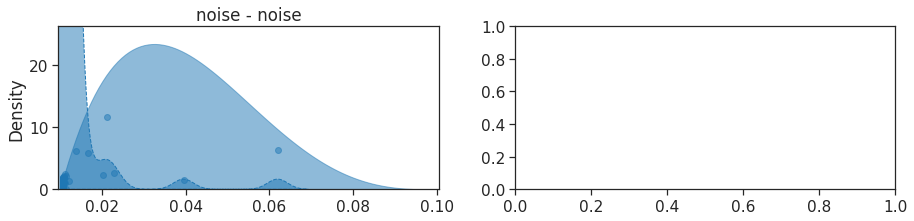

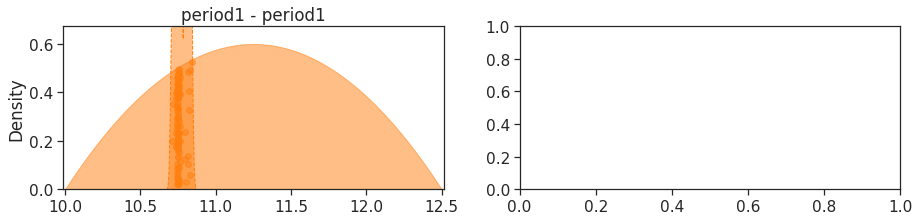

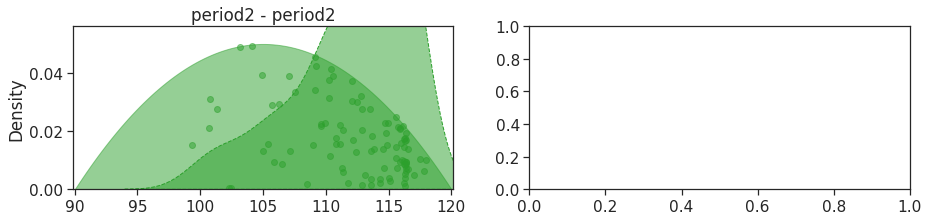

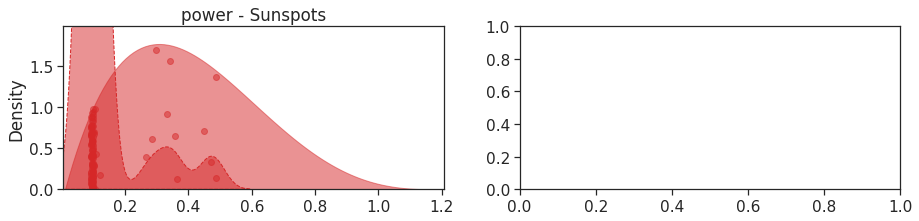

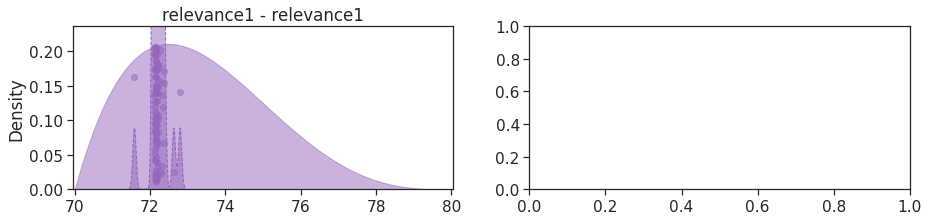

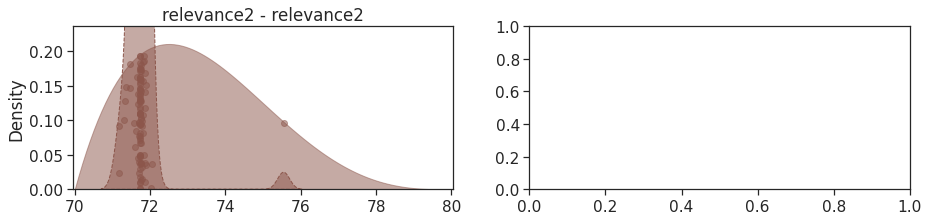

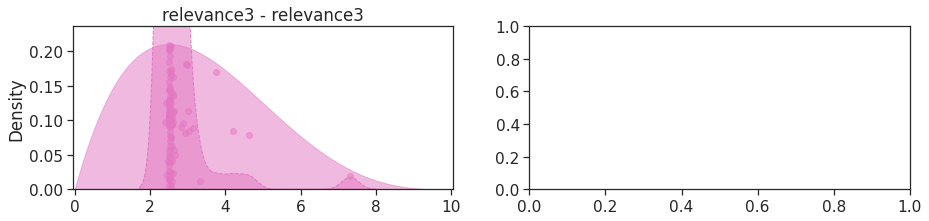

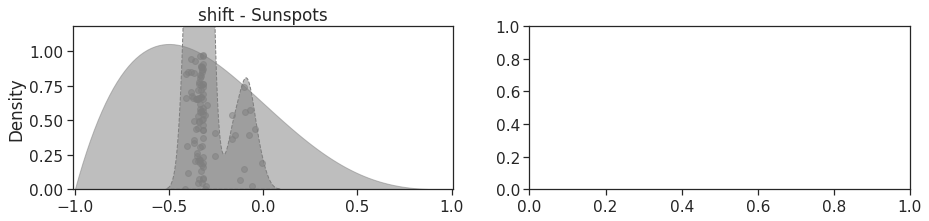

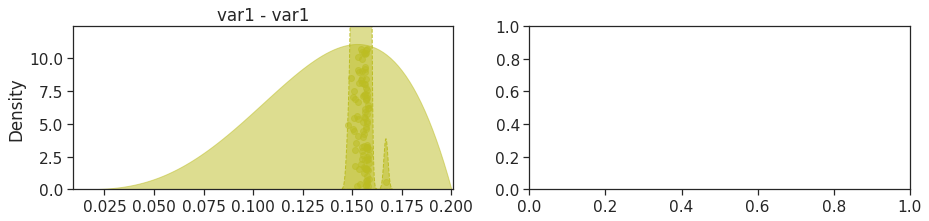

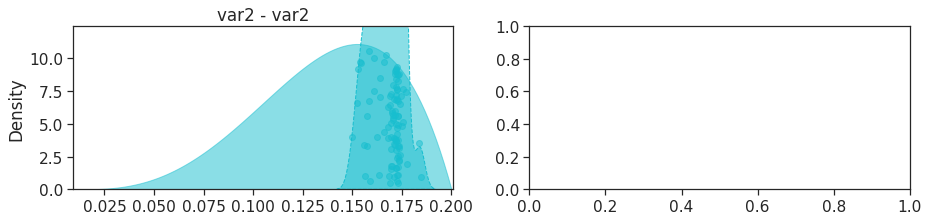

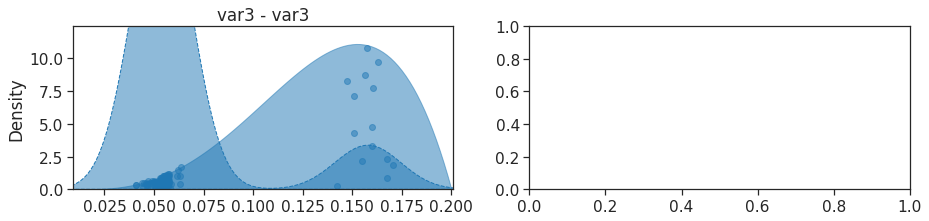

In [42]:
train(tgp_sm)

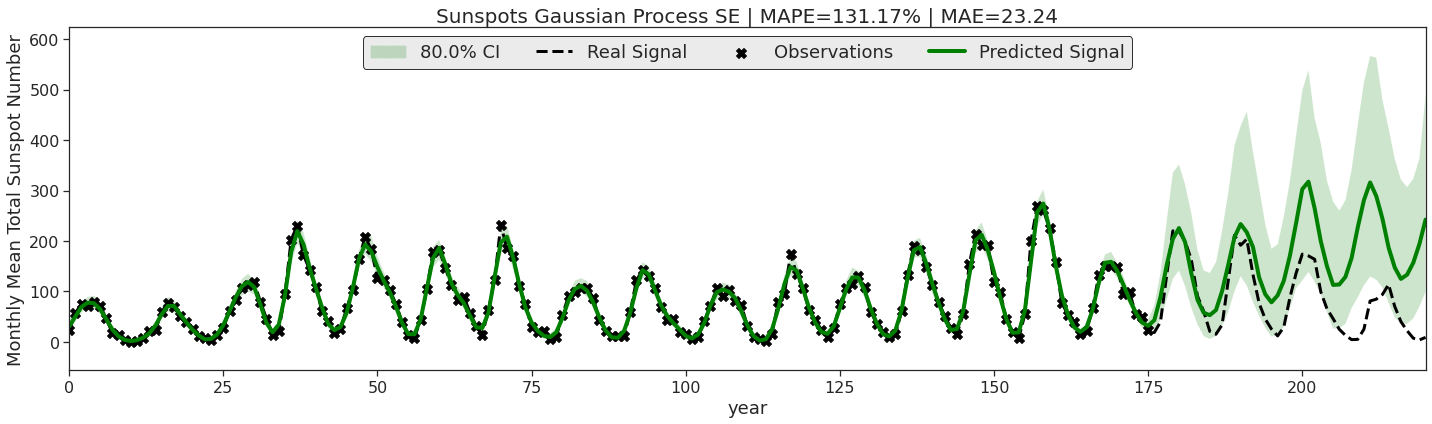

In [43]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

# Modelo Kernel SM + SE

<AxesSubplot: >

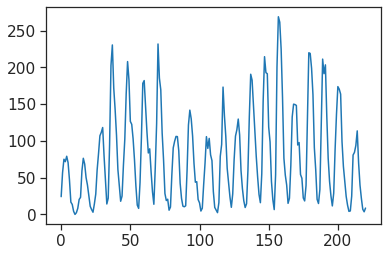

In [44]:
y_anual.plot()

In [45]:
from scipy.signal import periodogram

<ipython-input-46-397a1ae4f2d2>:3: RuntimeWarning: divide by zero encountered in divide
  tg.plt.plot(1/px, py)


(0.0, 150.0)

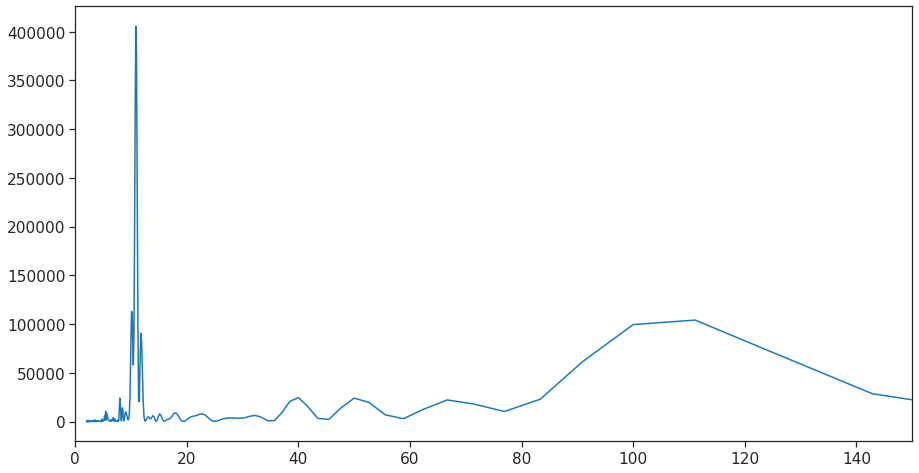

In [46]:
px, py = periodogram(y_anual.values, nfft=1000)
tg.plt.figure(1, figsize=(15,8))
tg.plt.plot(1/px, py)
tg.plt.xlim([0,150])

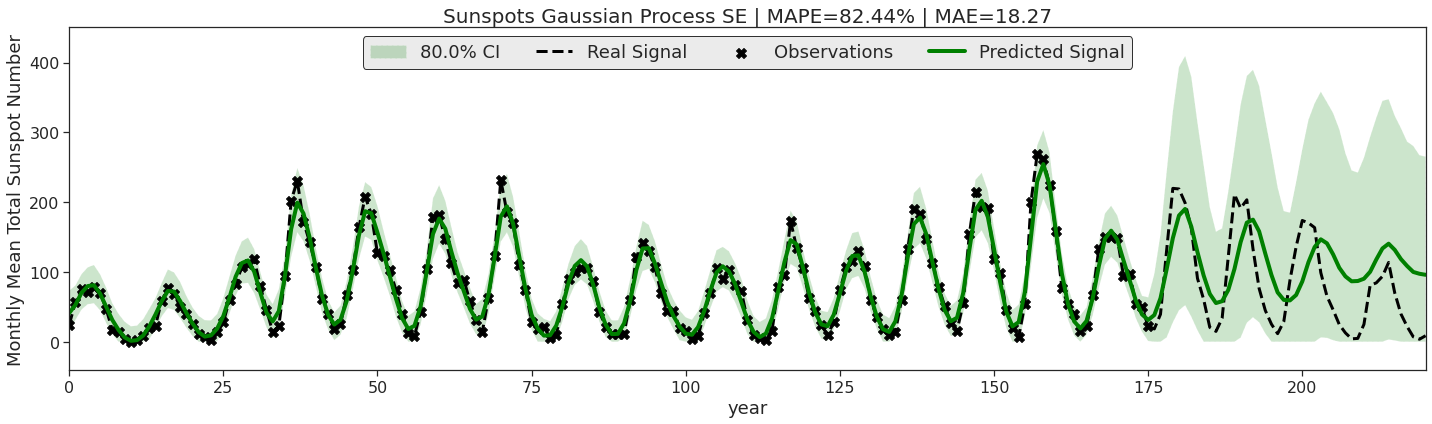

In [47]:
def model_sm(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_sm1 = tg.TgPrior('var1', ['var1'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance1 = tg.TgPrior('relevance1', ['relevance1'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period1 = tg.TgPrior('period1', ['period1'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel1 = tg.SM(var_sm1, relevance1, period1)

    var_se = tg.TgPrior('var3', ['var3'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance3 = tg.TgPrior('relevance3', ['relevance3'], dim=dim, low=0, high=10, alpha=2, beta=4) 
    kernel3 = tg.SE(var_se, relevance3)   
    
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    cov = tg.CovarianceTransport(kernel1 + kernel3, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

tgp_sm = model_sm(S_train, train_index_anual)

tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

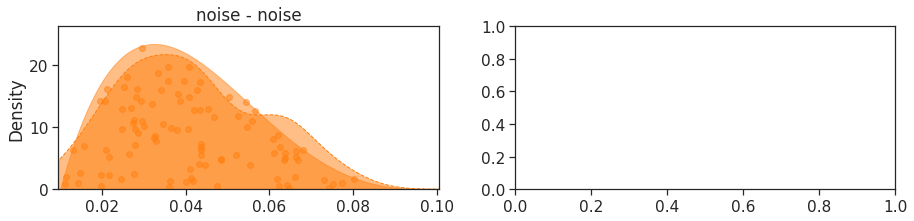

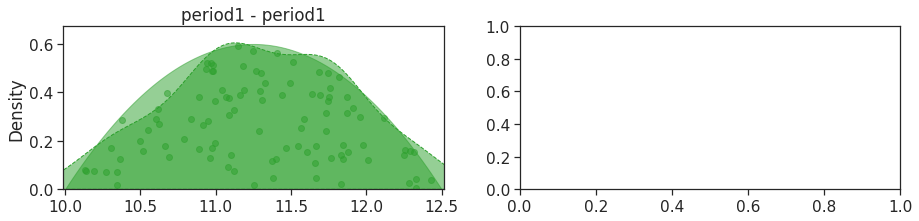

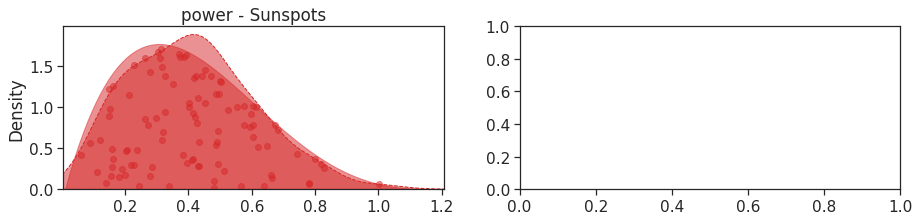

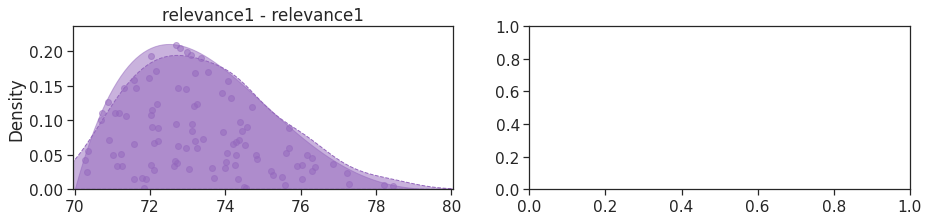

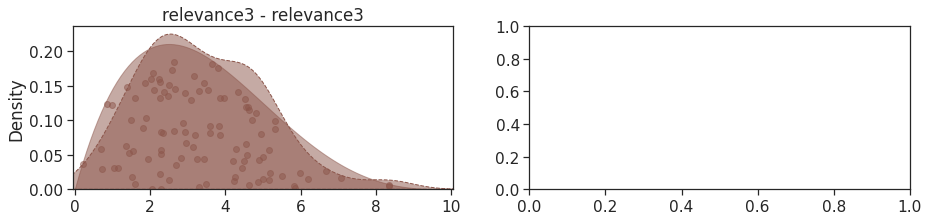

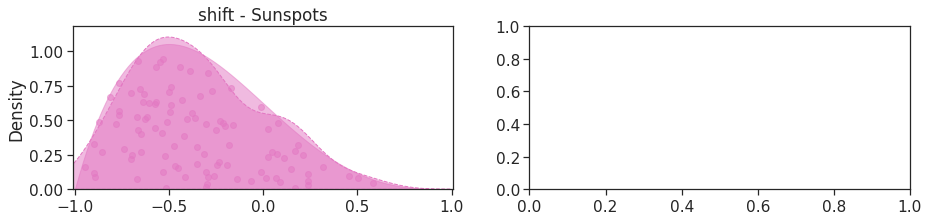

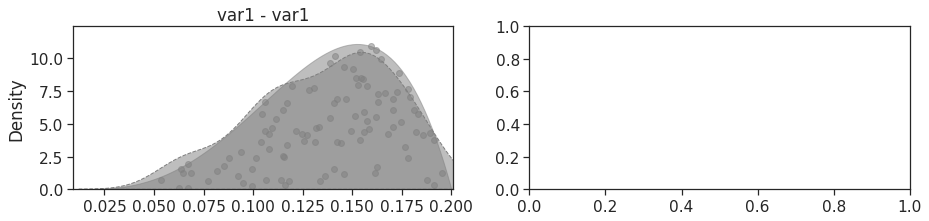

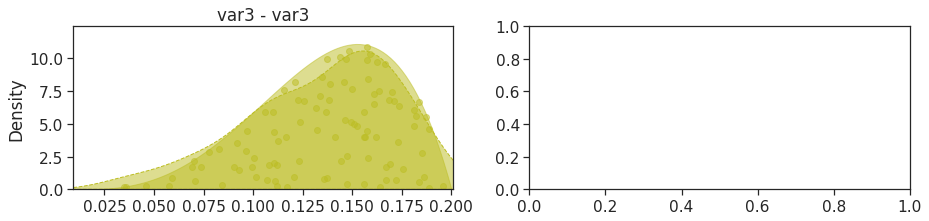

  0%|                                                                                                         …

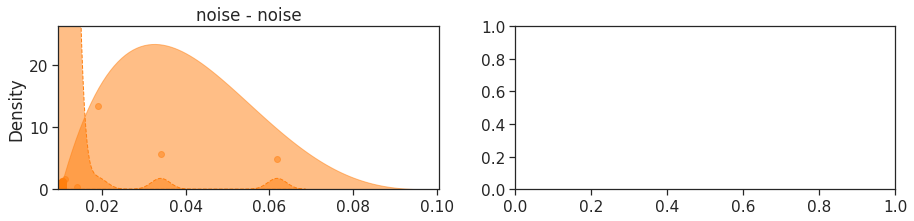

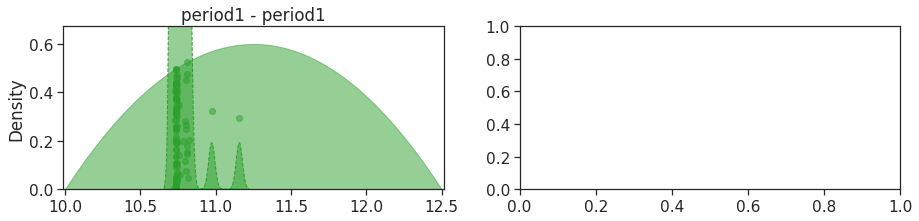

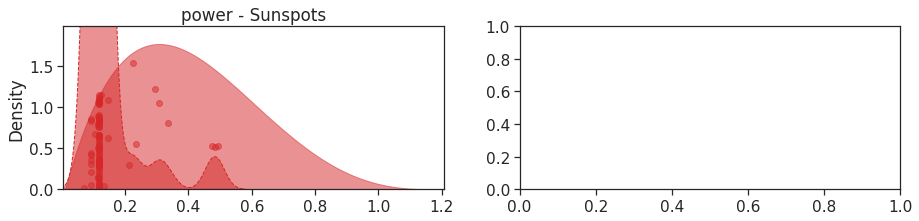

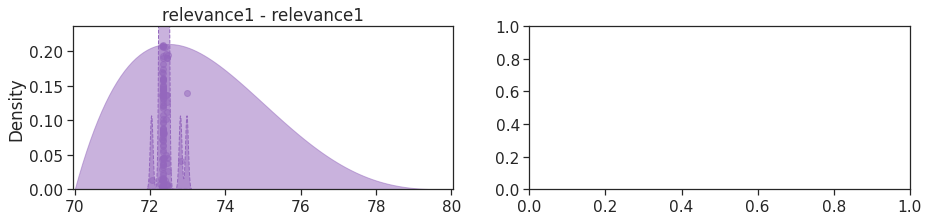

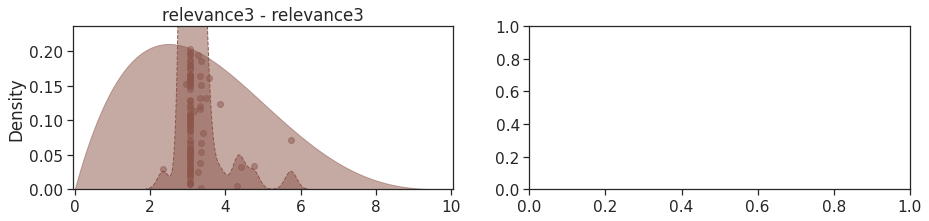

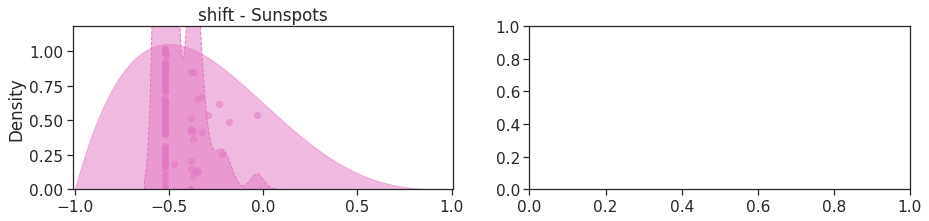

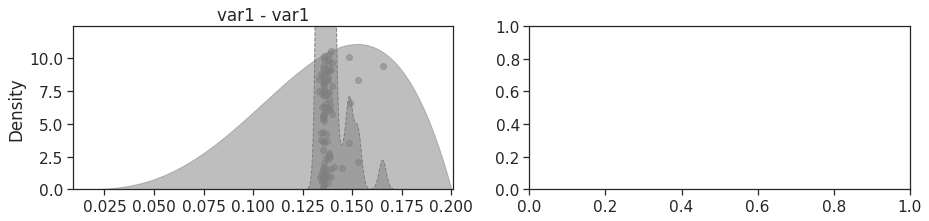

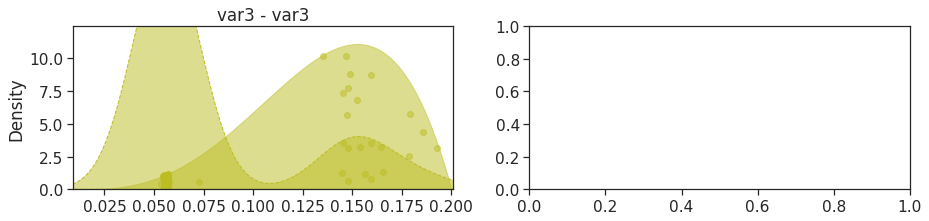

In [48]:
train(tgp_sm)

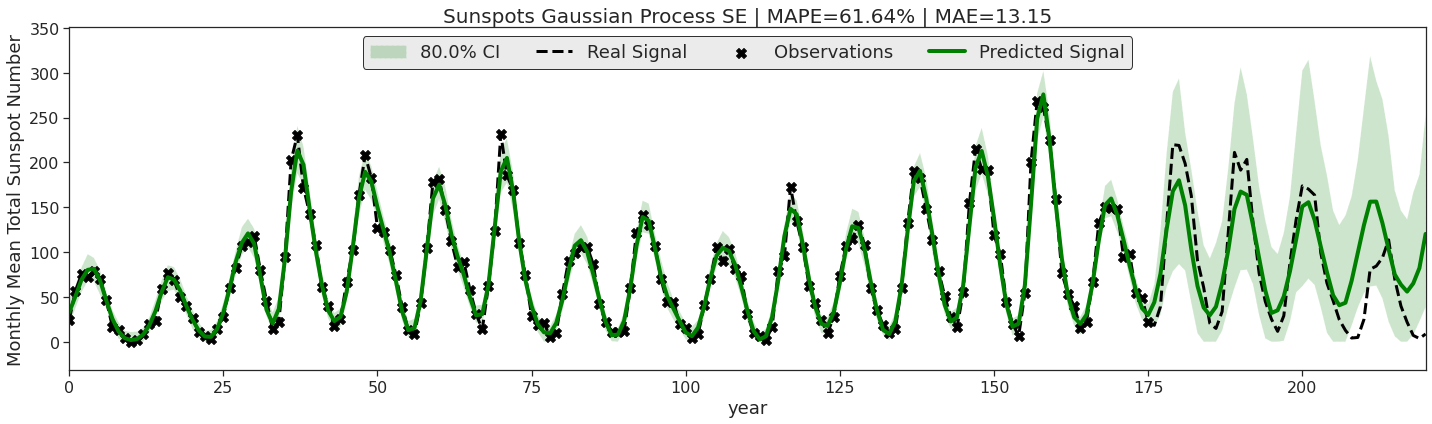

In [49]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

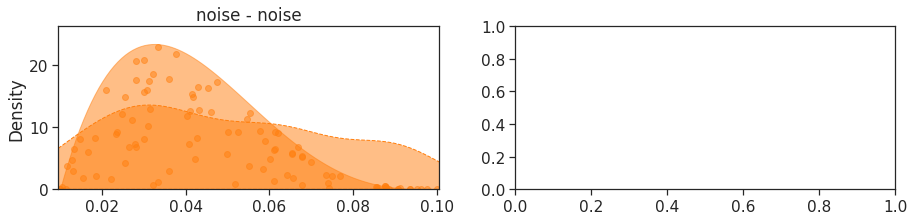

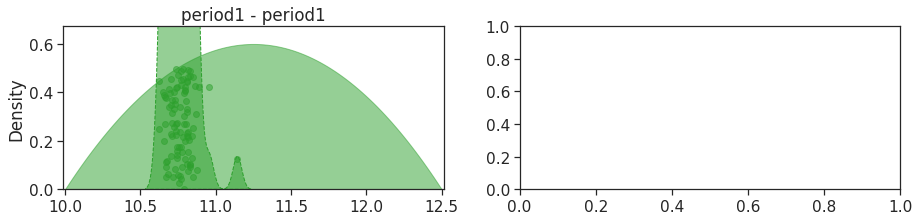

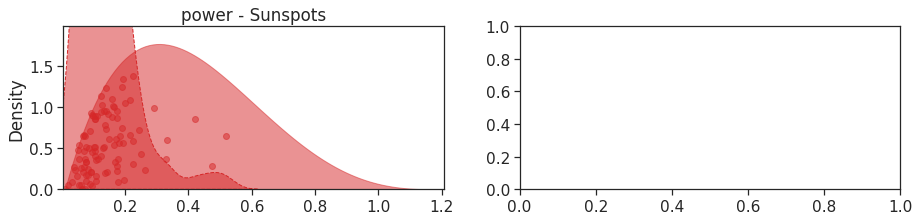

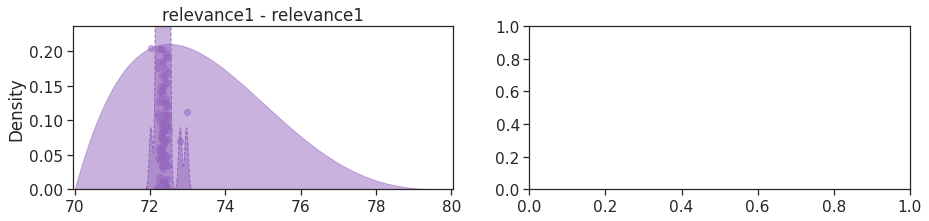

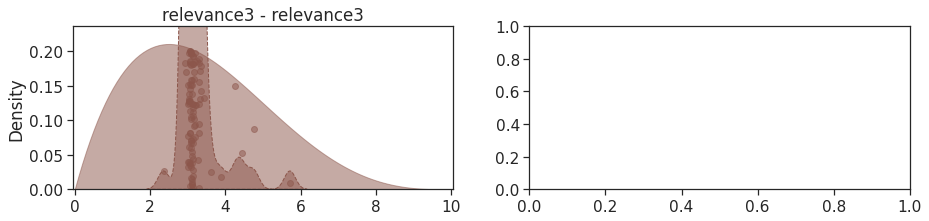

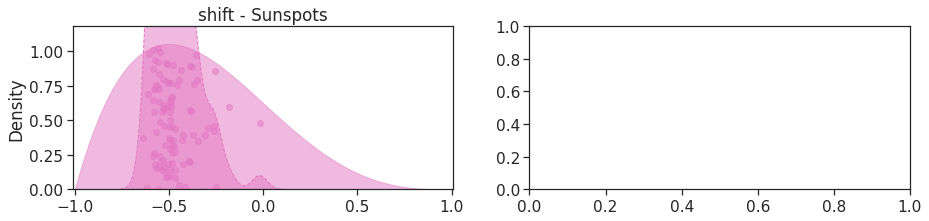

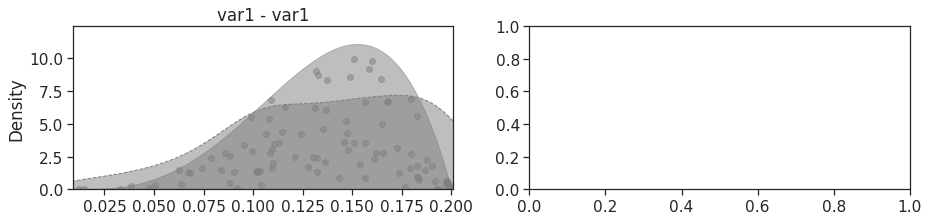

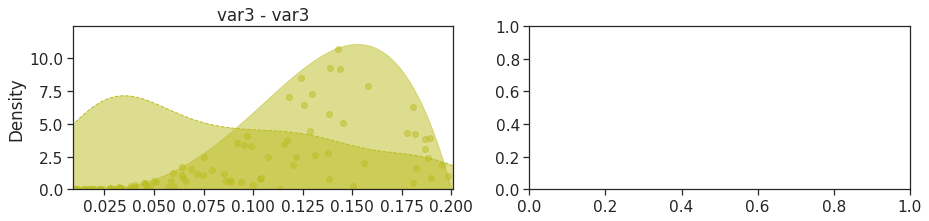

In [50]:
niters = 1000
#tgp_sm.sample_priors()
#tgp_sm.plot_priors(kde=True)
learning = tg.TgLearning(tgp_sm, lr=0.001, pbatch=0.8)
#learning.execute_sgd(niters)
learning.execute_svgd(niters)
tgp_sm.plot_priors(kde=True)

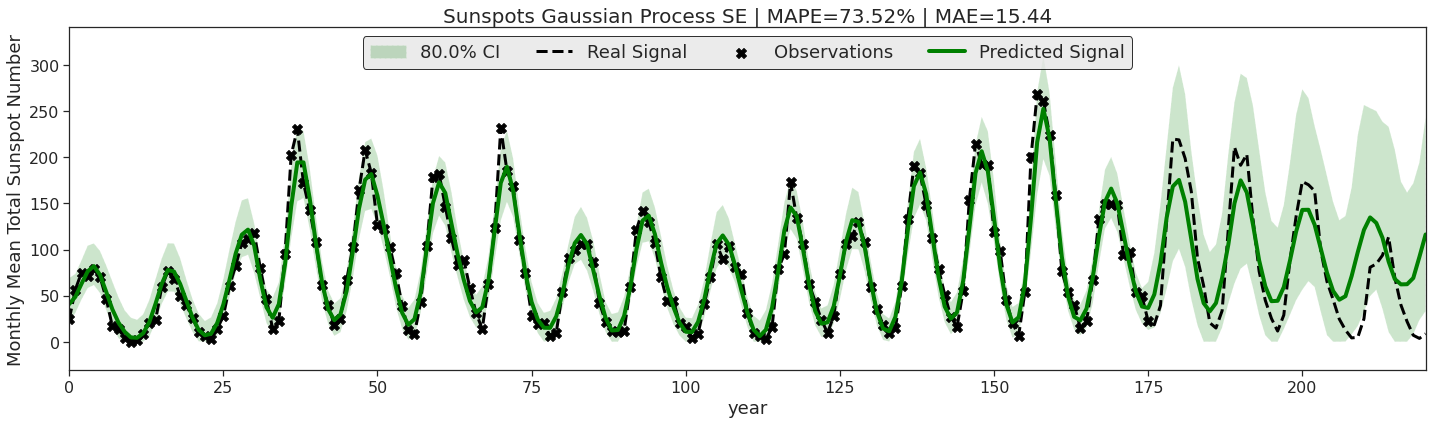

In [51]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

In [52]:
tgp_sm.sample_priors()

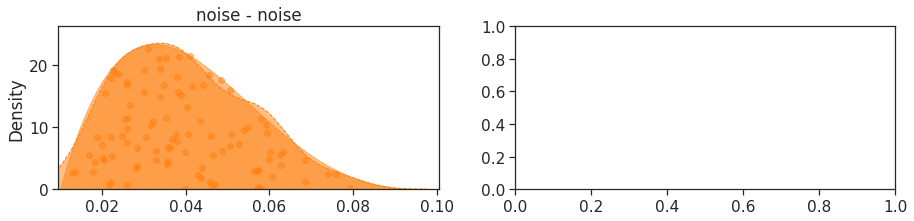

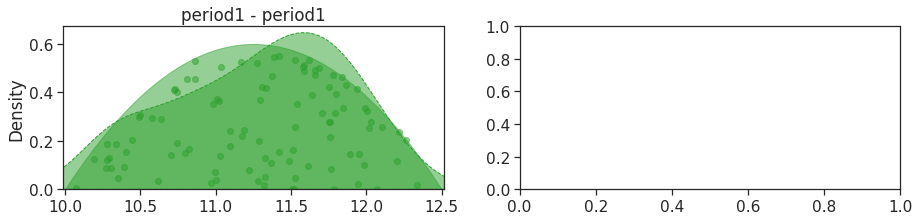

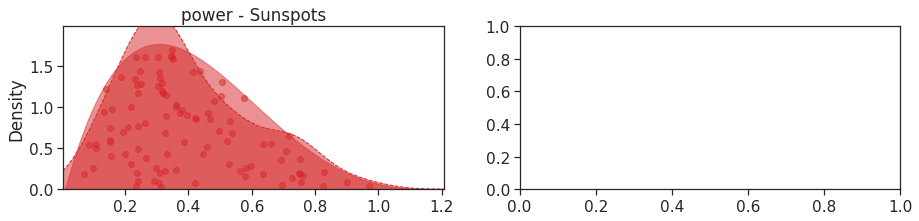

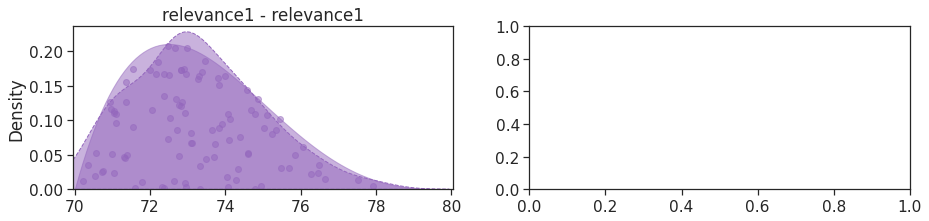

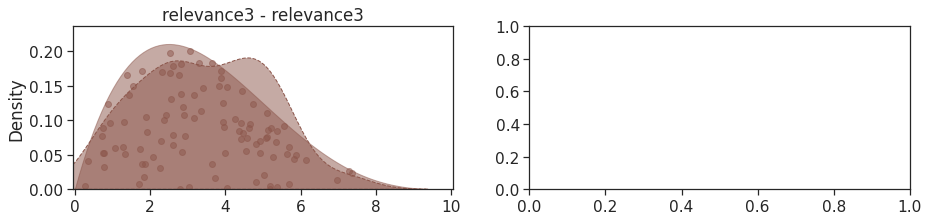

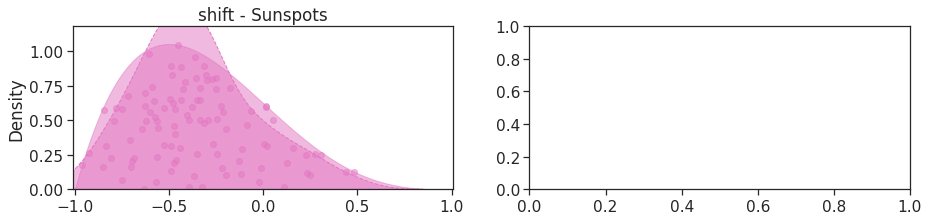

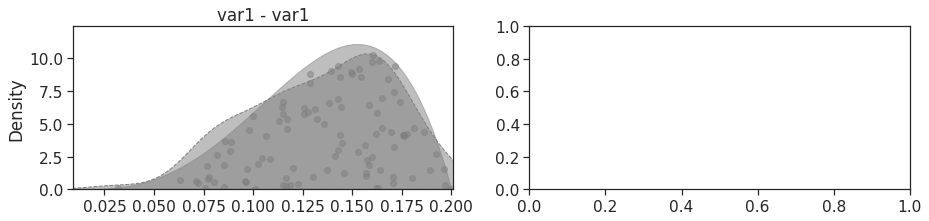

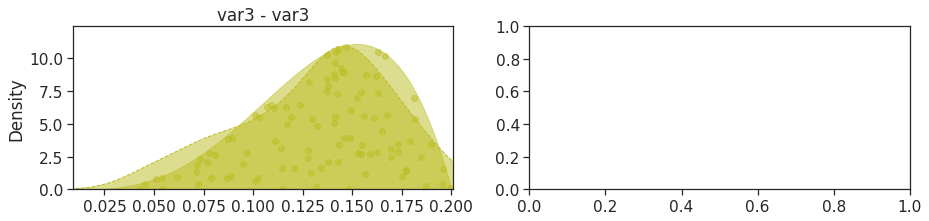

In [53]:
tgp_sm.plot_priors()

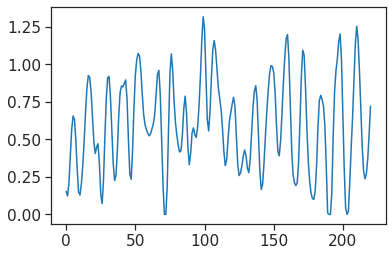

In [60]:
tg.plt.plot(tg.to_numpy(tgp_sm.prior(tgp_sm.dt.index)[0,:,0]).T);